# Unsupervised Learning: Trade & Ahead

## Problem Statement

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [221]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

#format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

import time

In [222]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=12)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="viridis",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage


    plt.show()  # show the plot

In [223]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
     # Draw lines for mean and median
    mean_val = data[feature].mean()
    median_val = data[feature].median()
    ax_hist2.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax_hist2.axvline(median_val, color='black', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    # Add legend to the histogram
    ax_hist2.legend()

## Loading the dataset

In [224]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [225]:
#Read the data
stock_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Unsupervised Learning/Project-Unsupervised Learning/stock_data.csv")

In [226]:
# copying data to another variable to avoid any changes to original data
stock = stock_data.copy()

## Data Overview

### Displaying the first few rows of the dataset

In [227]:
stock.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,AAL,American Airlines Group,Industrials,Airlines,42.35,10.00,1.69,135,51,-604000000,7610000000,11.39,668129938.50,3.72,-8.78
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.24,8.34,2.20,130,77,51000000,5144000000,3.15,1633015873.00,18.81,-8.75
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.91,11.30,1.27,21,67,938000000,4423000000,2.94,1504421769.00,15.28,-0.39
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.94,13.98,1.36,9,180,-240840000,629551000,1.26,499643650.80,74.56,4.20
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.32,-1.83,1.70,14,272,315120000,696878000,0.31,2247993548.00,178.45,1.06


### Displaying the last few rows of the dataset

In [228]:
stock.tail()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
335,YHOO,Yahoo Inc.,Information Technology,Internet Software & Services,33.26,14.89,1.85,15,459,-1032187000,-4359082000,-4.64,939457327.60,28.98,6.26
336,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,52.52,-8.70,1.48,142,27,159000000,1293000000,2.97,435353535.40,17.68,-3.84
337,ZBH,Zimmer Biomet Holdings,Health Care,Health Care Equipment,102.59,9.35,1.40,1,100,376000000,147000000,0.78,188461538.50,131.53,-23.88
338,ZION,Zions Bancorp,Financials,Regional Banks,27.30,-1.16,1.47,4,99,-43623000,309471000,1.20,257892500.00,22.75,-0.06
339,ZTS,Zoetis,Health Care,Pharmaceuticals,47.92,16.68,1.61,32,65,272000000,339000000,0.68,498529411.80,70.47,1.72


- The dataset has been loaded successfully

### Checking the shape of the dataset

In [229]:
stock.shape

(340, 15)

*  The dataset has 340 rows and 15 columns

### Checking the data types of the columns for the dataset

In [230]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

* There are a total of 340 non-null observations in each of the columns

* There are 4 columns of type **int64**

* There are 7 columns column of type **float64**

* 'Ticker Symbol', 'Security', 'GICS Sector 'and 'GICS Sub Industry ' are **objects**

### Getting the statistical summary for the numerical variables

In [231]:
stock.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Price,340.00,80.86,98.06,4.50,38.55,59.70,92.88,1274.95
Price Change,340.00,4.08,12.01,-47.13,-0.94,4.82,10.70,55.05
Volatility,340.00,1.53,0.59,0.73,1.13,1.39,1.70,4.58
ROE,340.00,39.60,96.55,1.00,9.75,15.00,27.00,917.00
Cash Ratio,340.00,70.02,90.42,0.00,18.00,47.00,99.00,958.00
Net Cash Flow,340.00,55537620.59,1946365312.18,-11208000000.00,-193906500.00,2098000.00,169810750.00,20764000000.00
Net Income,340.00,1494384602.94,3940150279.33,-23528000000.00,352301250.00,707336000.00,1899000000.00,24442000000.00
Earnings Per Share,340.00,2.78,6.59,-61.20,1.56,2.90,4.62,50.09
Estimated Shares Outstanding,340.00,577028337.75,845849595.42,27672156.86,158848216.10,309675137.80,573117457.32,6159292035.00
P/E Ratio,340.00,32.61,44.35,2.94,15.04,20.82,31.76,528.04


### Getting the statistical summary for the categorical variables

In [232]:
stock.describe(include='object').T

,count,unique,top,freq
Ticker Symbol,340,340,ZTS,1
Security,340,340,Zoetis,1
GICS Sector,340,11,Industrials,53
GICS Sub Industry,340,104,Oil & Gas Exploration & Production,16


*  Ticker Symbol and Security(which is the company name) has 340 non null unique values which shows none of the companies are duplicated

### Check for missing values

In [233]:
# missing value check
stock.isnull().sum()

,0
Ticker Symbol,0
Security,0
GICS Sector,0
GICS Sub Industry,0
Current Price,0
Price Change,0
Volatility,0
ROE,0
Cash Ratio,0
Net Cash Flow,0


* There are no missing values in any of the columns

### Check for Duplicate Values

In [234]:
stock.duplicated().sum()

np.int64(0)

* There are no duplicate values in the data

## Exploratory Data Analysis (EDA)


### Univariate analysis

**`Current Price`**

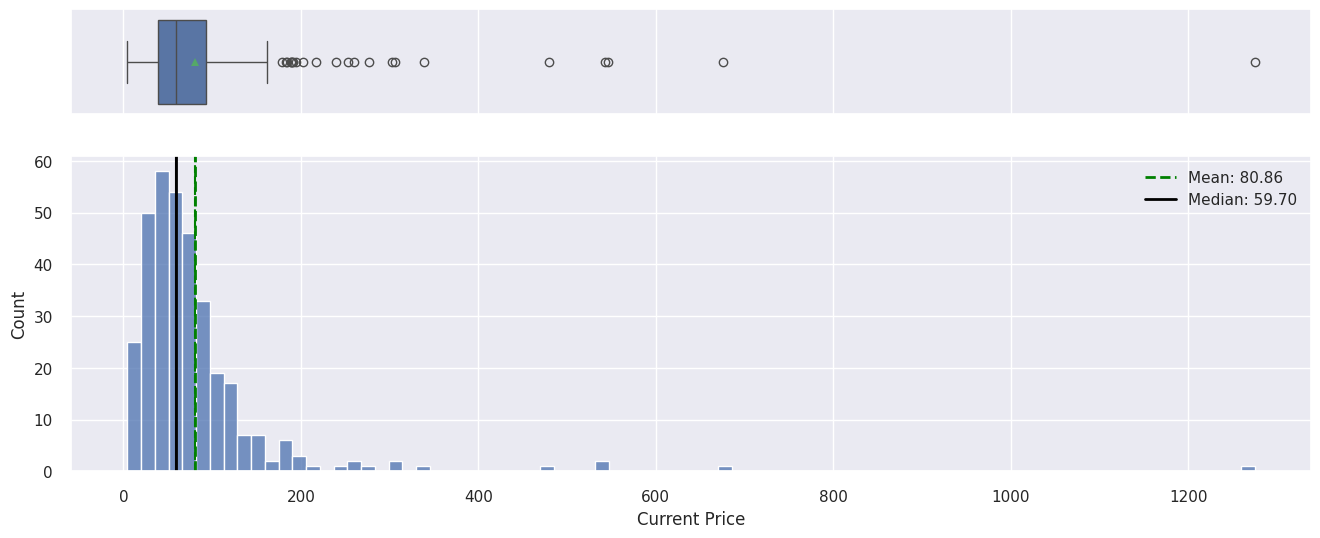

In [235]:
histogram_boxplot(stock, 'Current Price')

*  The distribution for current price is heavily right skewed
*  Majority of the stocks are priced lower (below 100$) with very few stocks having higher price
* No stock is listed with price at 0 or below

**`Price Change`**

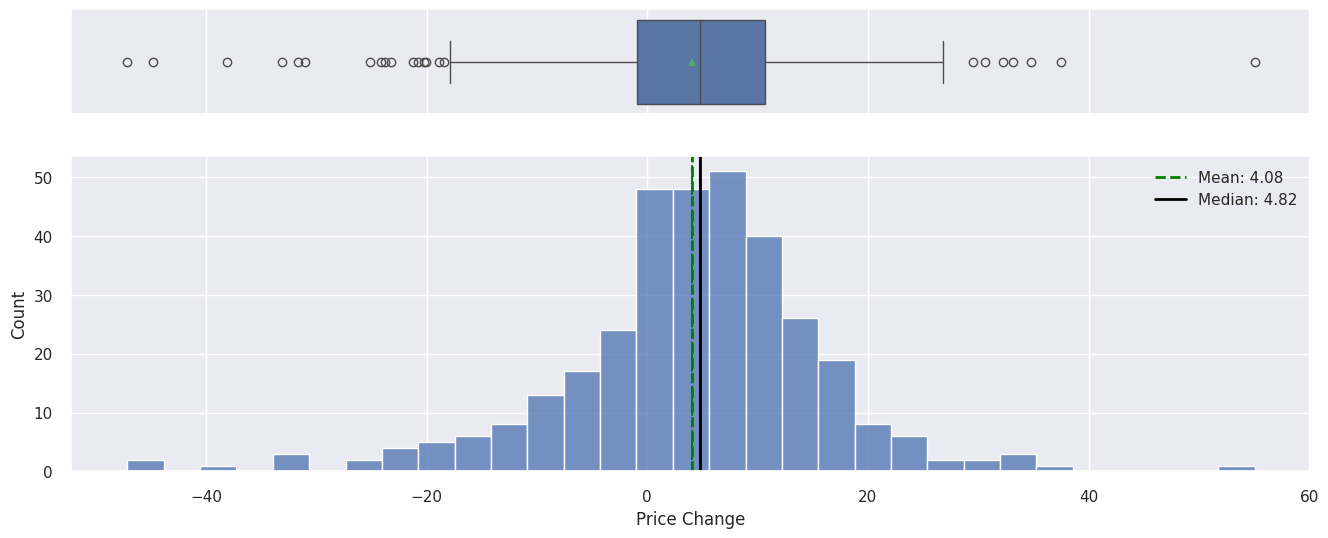

In [236]:
histogram_boxplot(stock, 'Price Change')

*  The distribution of Price Change is a normal distribution but with some outliers on both ends—especially more extreme negative changes

**`Volatility`**

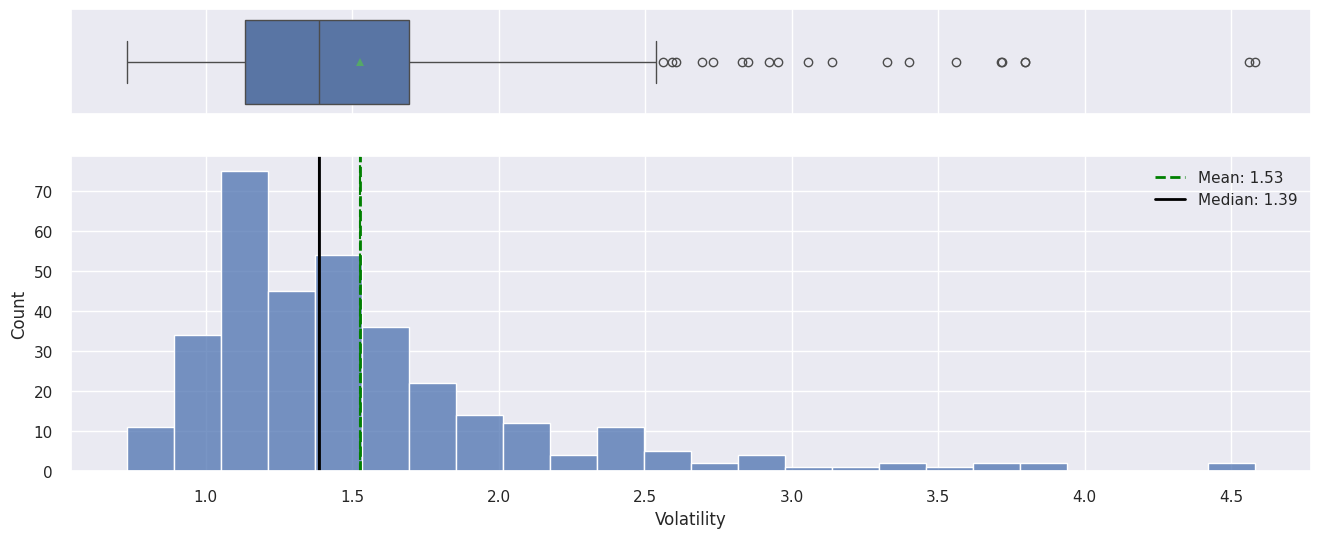

In [237]:
histogram_boxplot(stock, 'Volatility')

* The distribution of Volatility is also right skewed.This shows most of the stocks have low volatility and very few stocks have high volatility

**`ROE`**

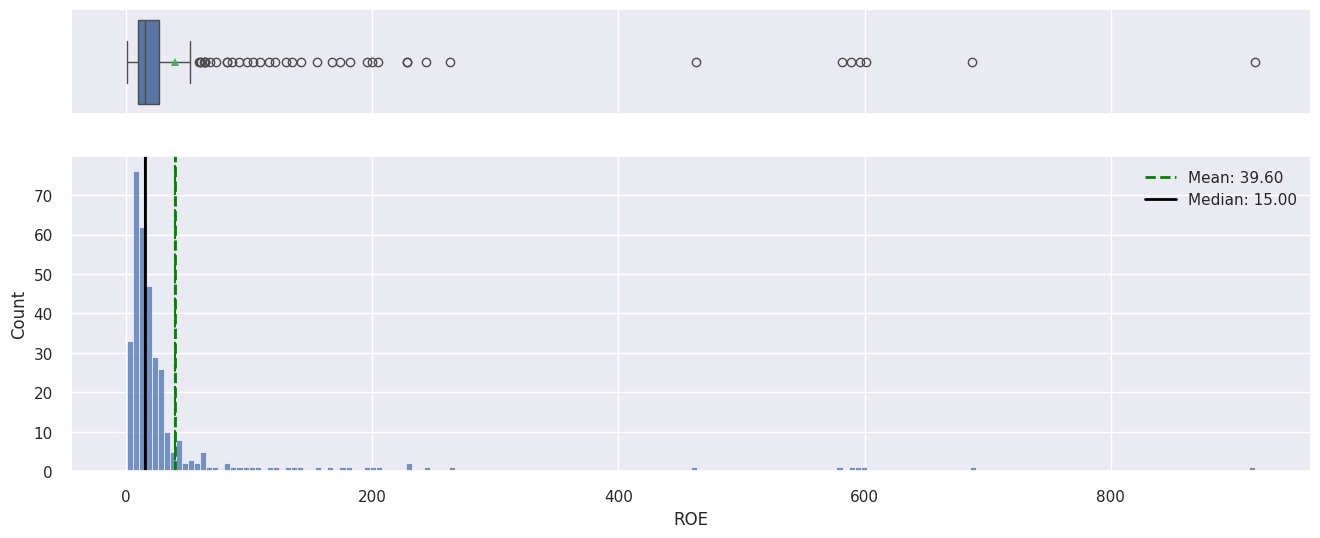

In [238]:
histogram_boxplot(stock, 'ROE')

* ROE distribution is heavily right skewed indicating most stocks have lower returns on equity with very few stocks having high returns on equity


**`Cash Ratio`**

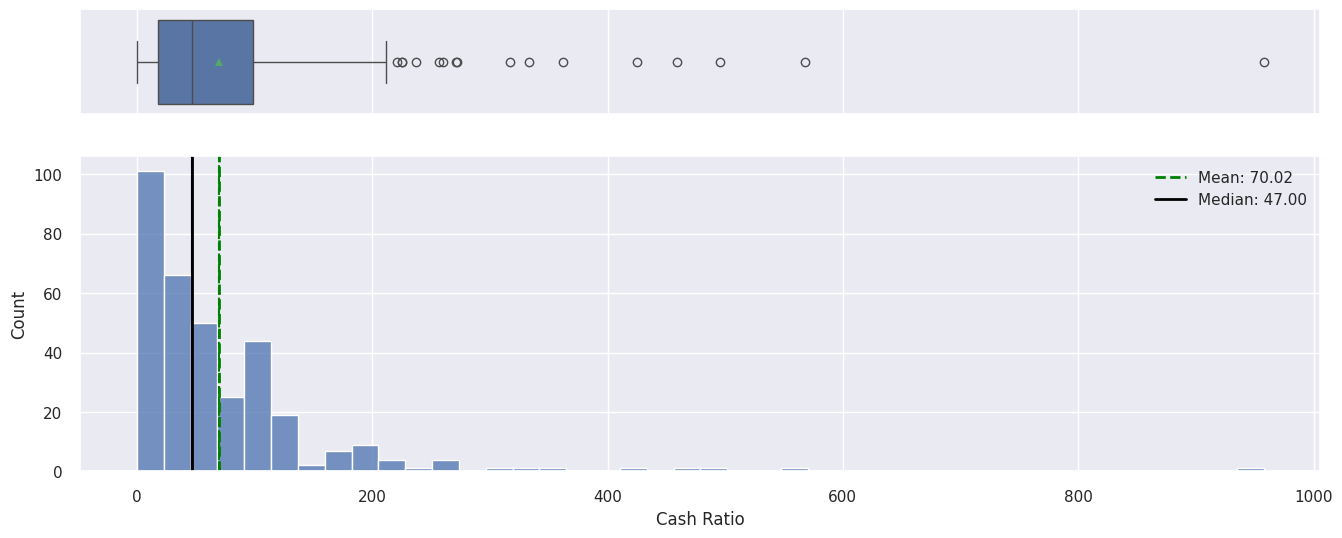

In [239]:
histogram_boxplot(stock, 'Cash Ratio')

* Cash Ratio is also heavily right skewed with many outliers
*  Most of the stocks have Cash Ratio >1 indicating high Cash Ratio
*  Technically a super high cash ratio isn’t always great either—it could mean the company isn’t using its cash effectively (e.g., not investing or growing).



**`Net Cash Flow`**

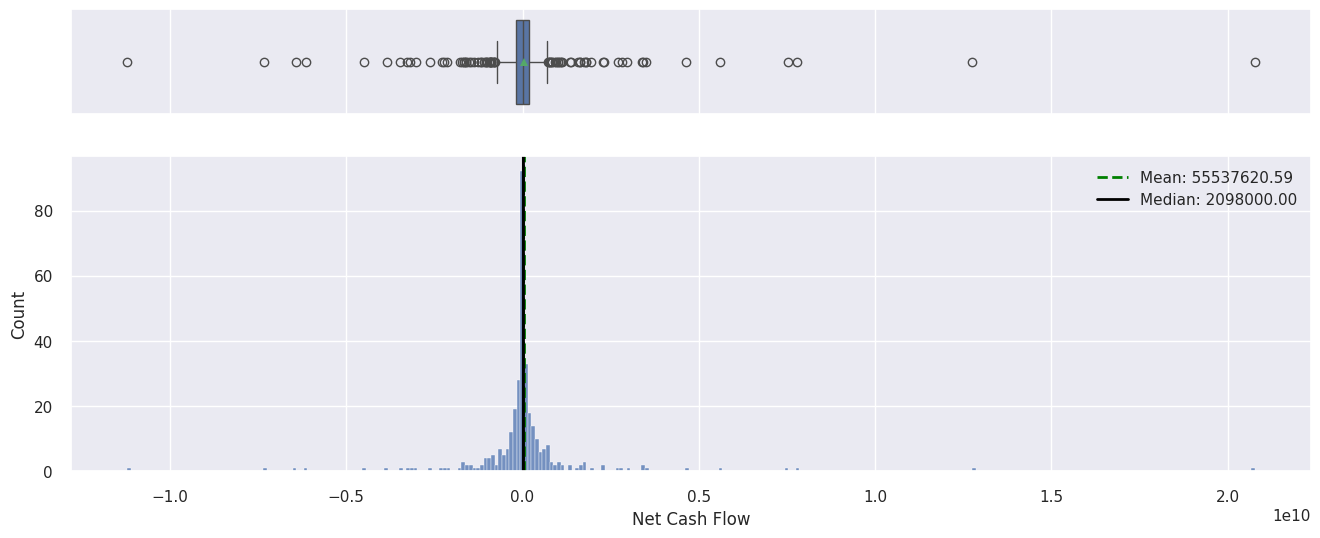

In [240]:
histogram_boxplot(stock, 'Net Cash Flow')

* The distribution of Net Cash Flow is normally distributed but many outliers are present on both ends

**`Net Income`**

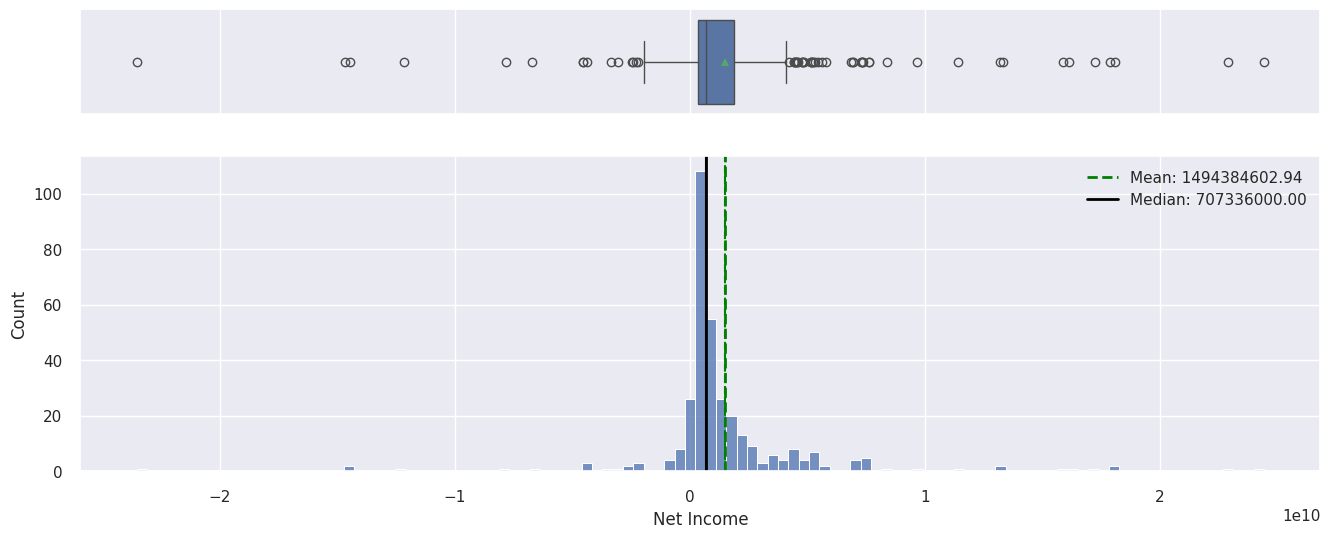

In [241]:
histogram_boxplot(stock, 'Net Income')

* The Net income is shown to be right skewed with both long positive and negative tail
*  Right skewness in net income suggests most companies earn a modest income, with some outliers indicating substantial profits or losses

**`Earnings Per Share`**

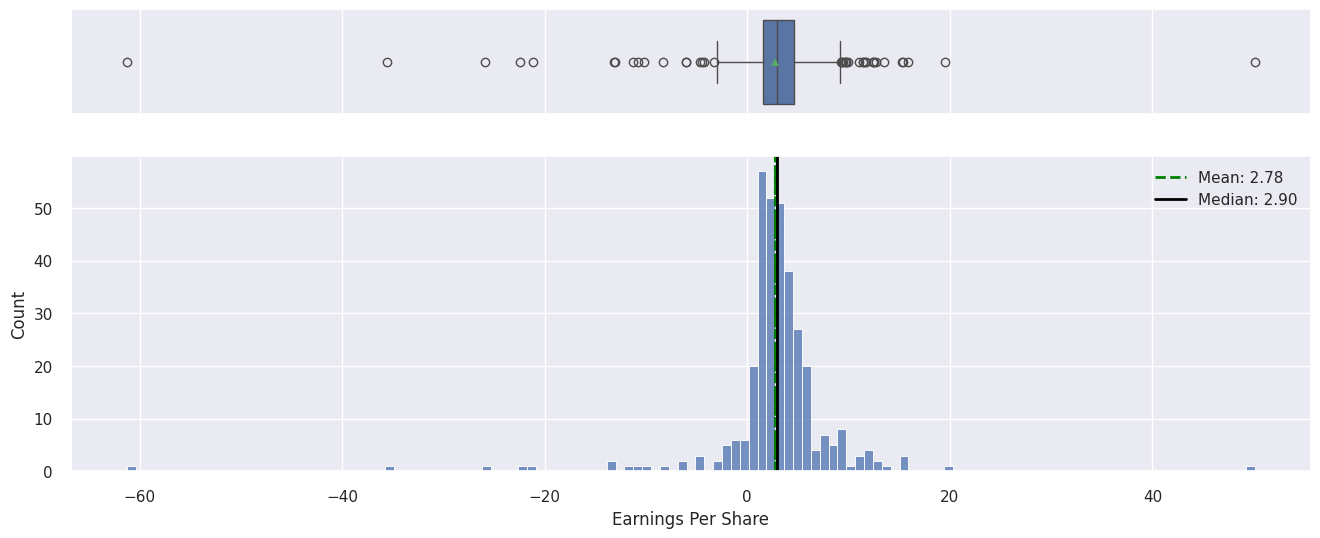

In [242]:
histogram_boxplot(stock, 'Earnings Per Share')

*  The distribution in the case of Earnings per share is a normal distribution.
* Earnings Per Share has both positive and negative values

**`Estimated Shares Outstanding`**

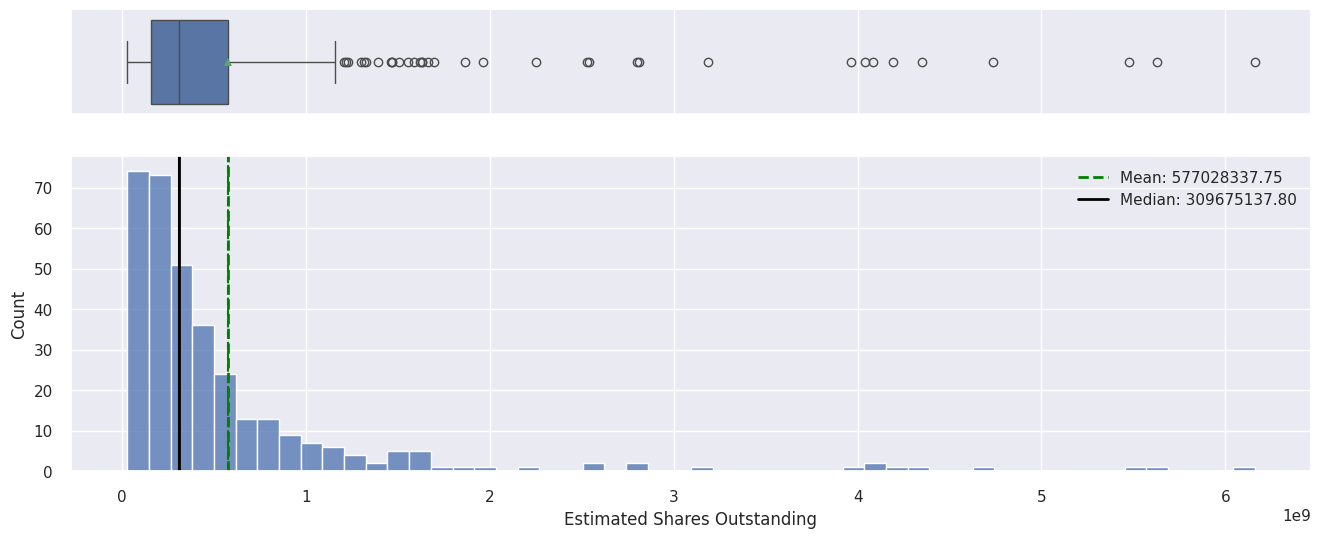

In [243]:
histogram_boxplot(stock, 'Estimated Shares Outstanding')

* This distribution is also right skewed with majority of the stocks having lower value of Estimated shares outstanding
* Very few shares have higher value of Estimated Shares Outstanding,but those high values are not unrealistic

**`P/E Ratio`**

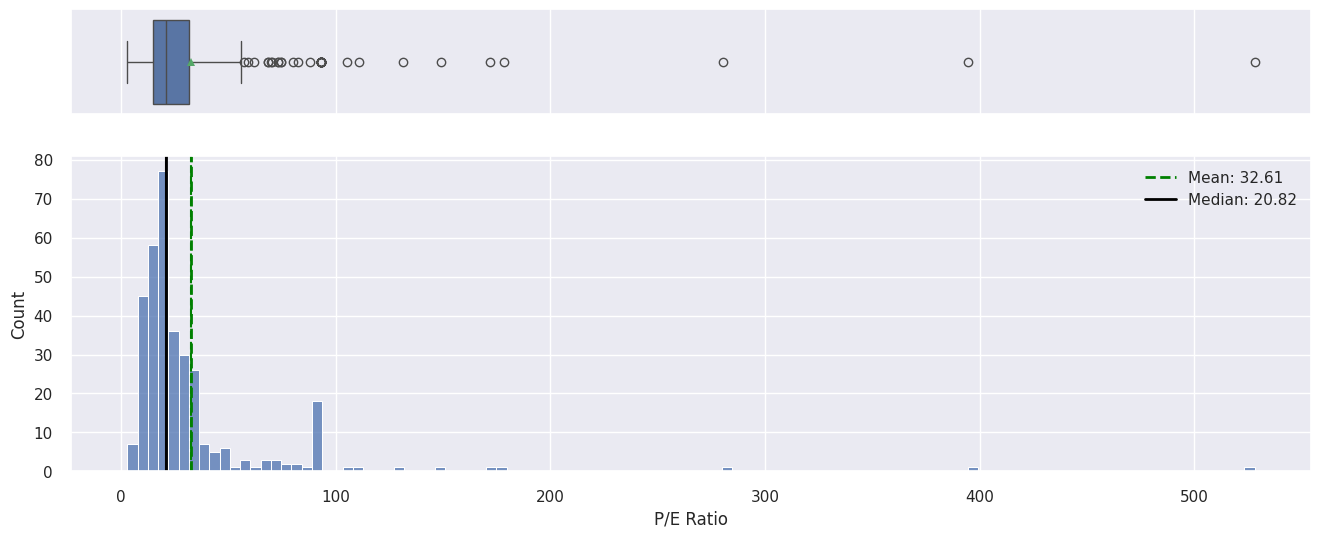

In [244]:
histogram_boxplot(stock, 'P/E Ratio')

* A right-skewed P/E ratio distribution indicates most stocks have a lower price compared to their earnings, with some having exceptionally high ratios which could suggest overvaluation.

**`P/B Ratio`**

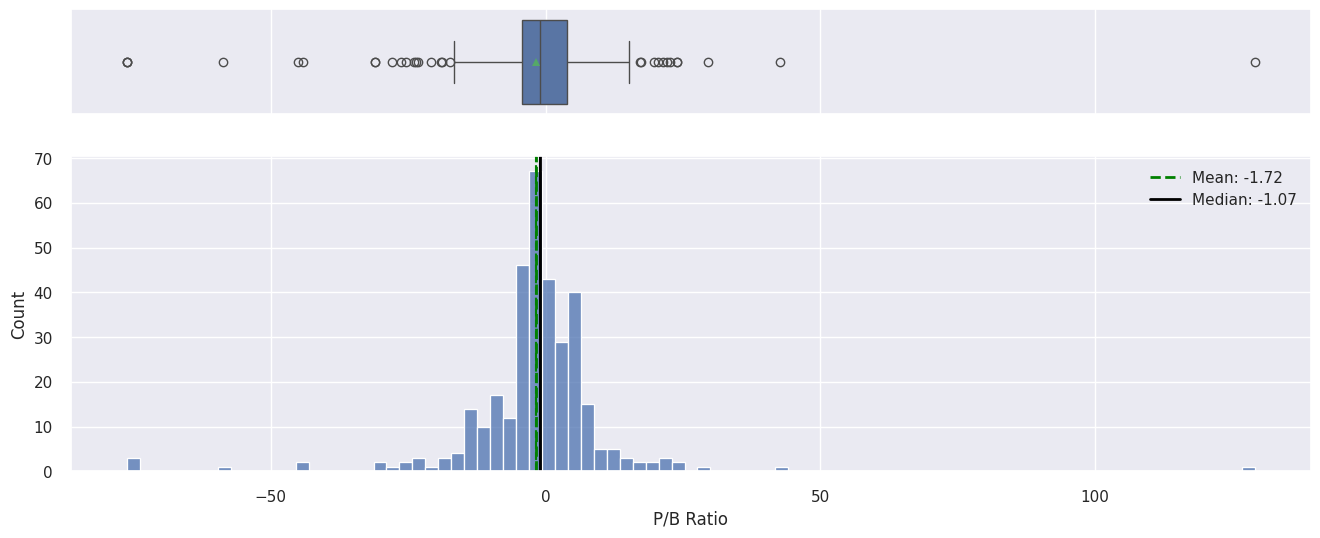

In [245]:
histogram_boxplot(stock, 'P/B Ratio')

*  The distribution of P/B ratio is normally distributed with outliers on both ends

**1. What does the distribution of stock prices look like?**

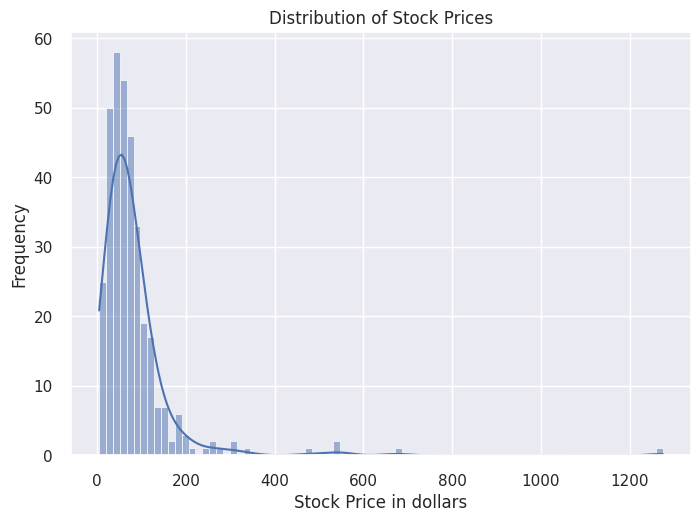

In [246]:
sns.histplot(data=stock, x='Current Price', kde=True)
plt.title('Distribution of Stock Prices')
plt.xlabel('Stock Price in dollars')
plt.ylabel('Frequency')
plt.show()

*  The distribution of stock prices is left skewed,with majority of the stocks within the price range <100$

### Distribution of GICS Sector

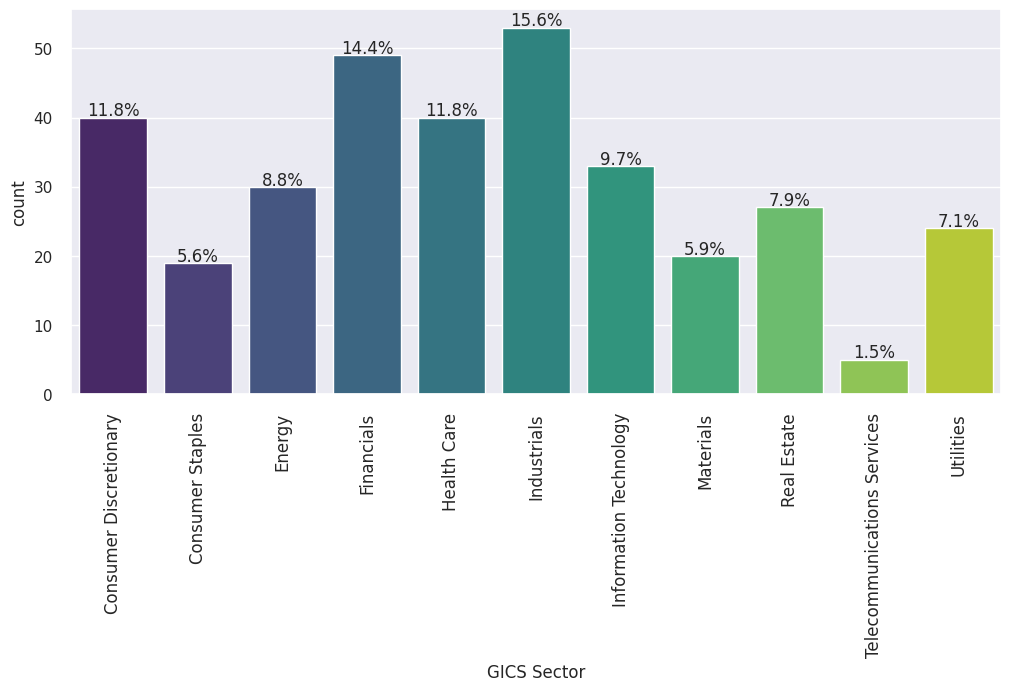

In [247]:
labeled_barplot(stock, 'GICS Sector', perc=True)

*  Industrials and Financials sectors lead in distribution, while Telecommunications Services is the least represented in the dataset.

In [248]:
stock['GICS Sector'].value_counts().sort_values(ascending=False)

,count
GICS Sector,
Industrials,53
Financials,49
Health Care,40
Consumer Discretionary,40
Information Technology,33
Energy,30
Real Estate,27
Utilities,24
Materials,20


* The stocks are drawn from 11 different industrial sectors,
* The top 4 of the 11 sectors (industrials, financials, consumer discretionary, and health care) comprise over half of the total number of stocks

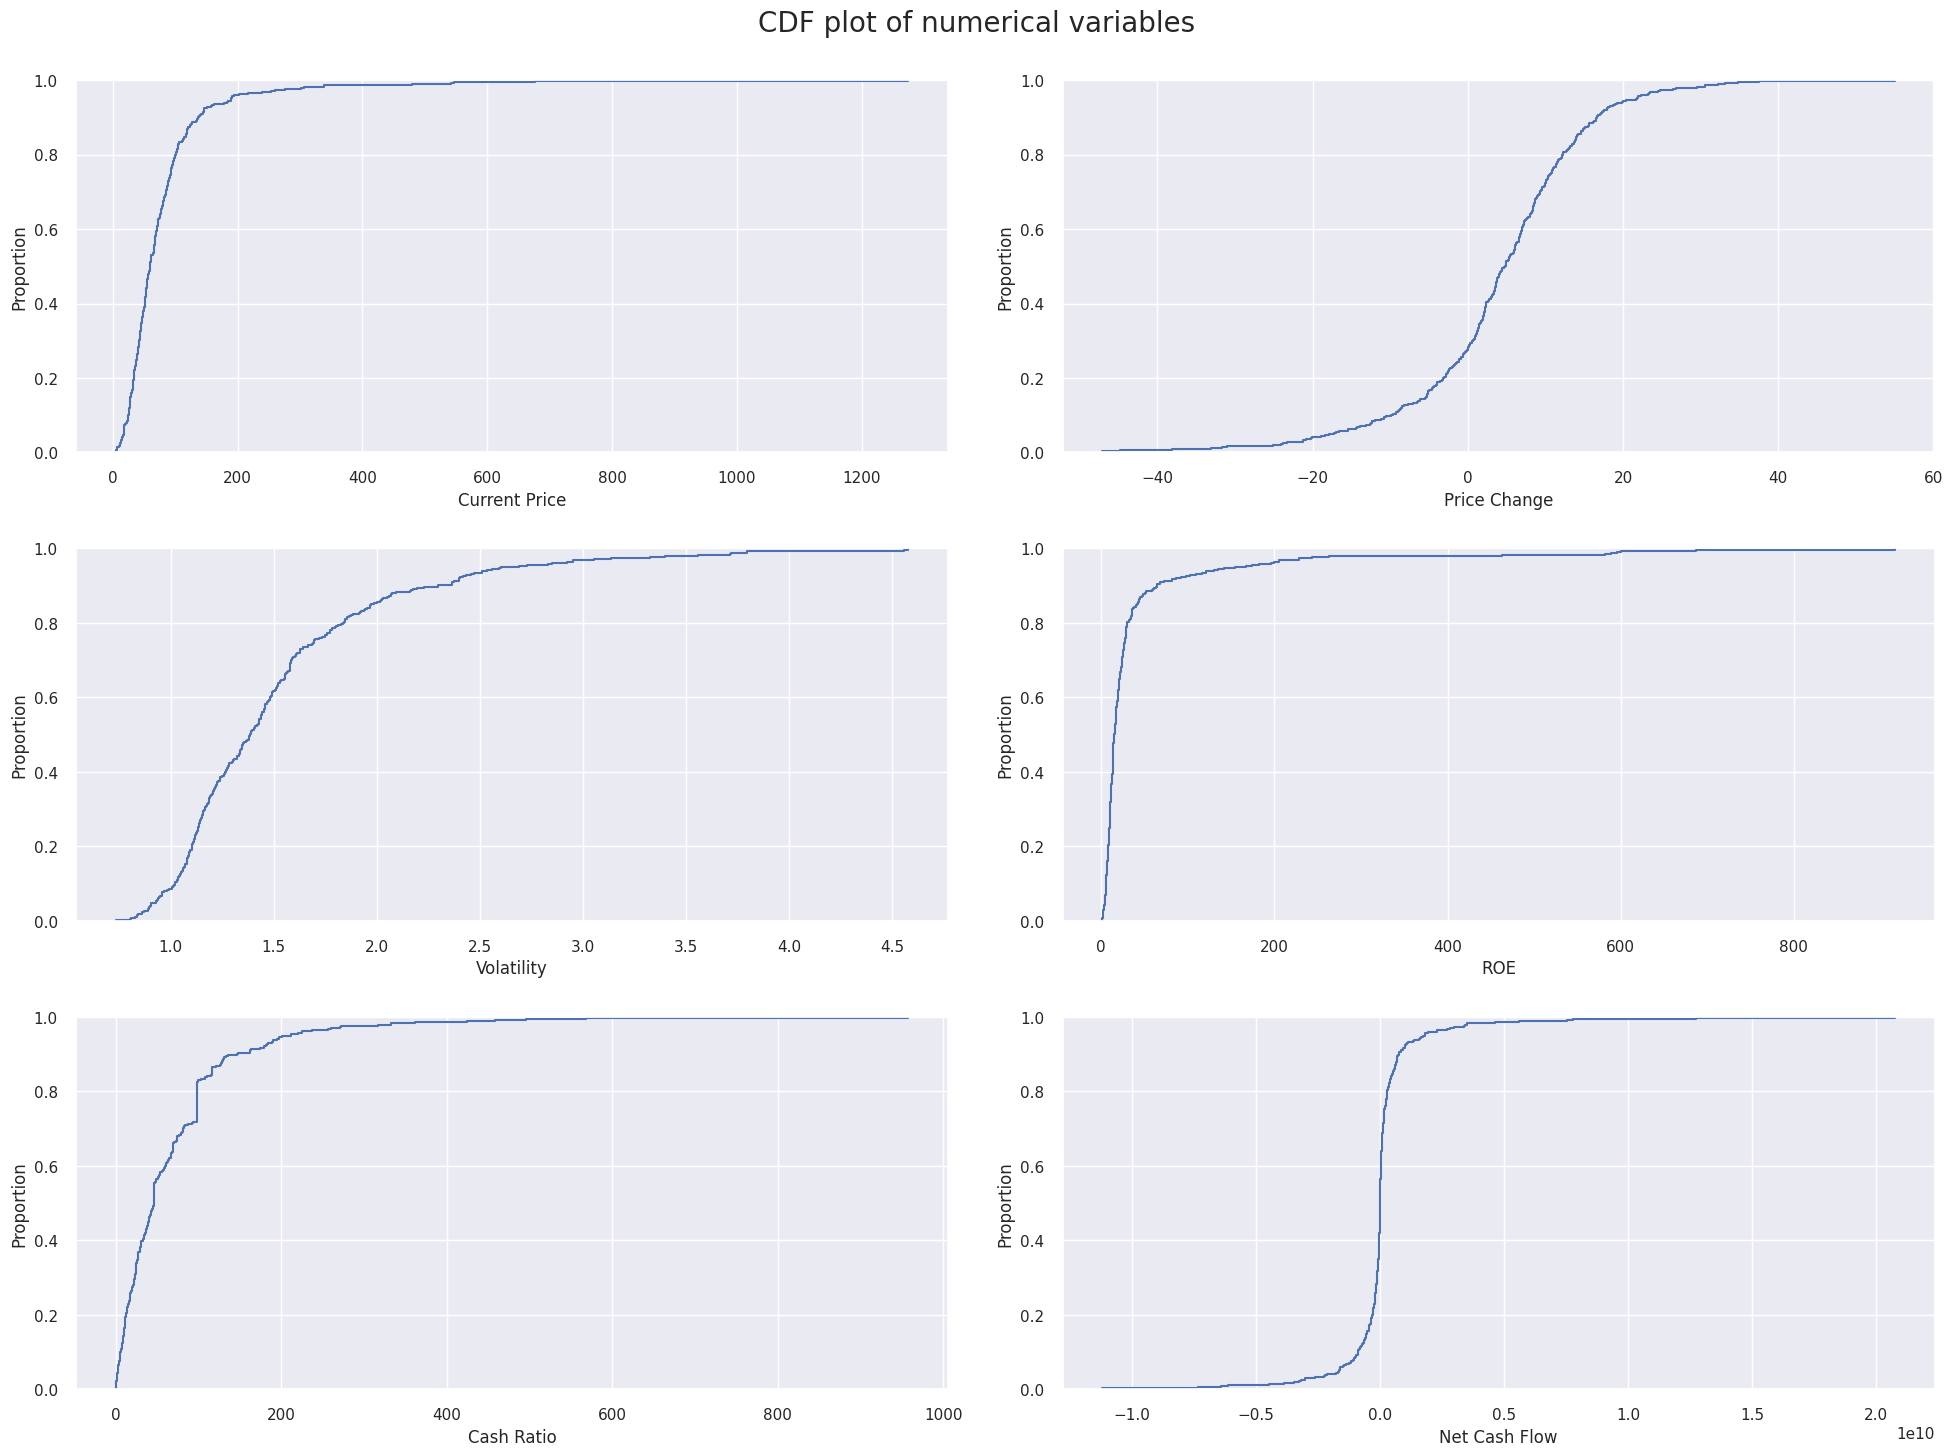

In [249]:
num_cols = stock.select_dtypes(include = np.number).columns.to_list()
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=stock[num_cols[counter]])
    counter = counter + 1
    if counter != 4:
        sns.ecdfplot(ax=axes[ii][1], x=stock[num_cols[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)
plt.show()

* About 96% of stock's Current Price is less than 200$
* For about 90% of stocks the volatility is less than 2.5
* for about 20% of stocks Net Cash flow is below 0,for 40 % Net cash flow = 0
* For about 90% of stocks Cash Ratio is below 200,out of that almost 20% has Cash ratio less than 1
* ROE is less than 200 for 90% of stocks
* About 30 % of stocks have price change less than or equal to 0

### Bivariate analysis

2. **The stocks of which economic sector have seen the maximum price increase on average?**

In [250]:
sector_df=stock.groupby("GICS Sector")['Price Change'].mean().sort_values(ascending = False)
sector_df


,Price Change
GICS Sector,
Health Care,9.59
Consumer Staples,8.68
Information Technology,7.22
Telecommunications Services,6.96
Real Estate,6.21
Consumer Discretionary,5.85
Materials,5.59
Financials,3.87
Industrials,2.83


Text(0, 0.5, 'Average Price Change ')

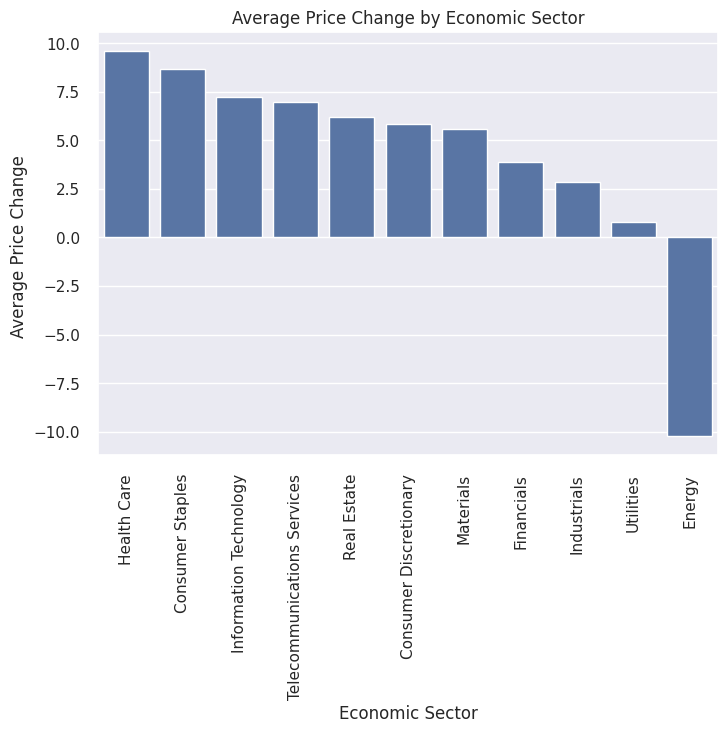

In [251]:
sns.barplot(data=sector_df.reset_index(), x='GICS Sector', y='Price Change')
plt.xticks(rotation=90)
plt.title('Average Price Change by Economic Sector')
plt.xlabel('Economic Sector')
plt.ylabel('Average Price Change ')

* **Health care** economic sector has seen the maximum price increase on average

**3. How are the different variables correlated with each other?**

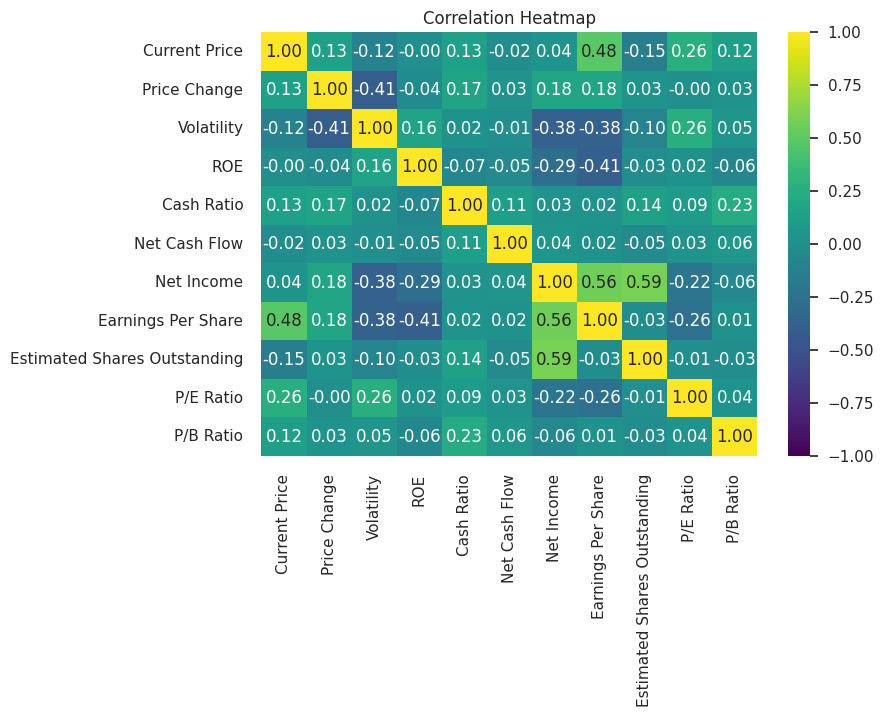

In [252]:
sns.heatmap(stock[num_cols].corr(),annot = True, cmap='viridis',vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Observations:
*  There seems to have no strong correlation between different variables.
*  Several variables are moderately correlated (+/- .40) with one another
      *  Volatility is negatively correlated with price change, i.e., as a stock
becomes more volatile, its price is likely dropping
      *Net income is negatively correlayed with volatility, i.e. as a company generates higher net income its price is likely less volatile
      *Net income is also positively correlated with earnings per share (EPS) and estimated shares outstanding
      *EPS is positively correlated with current price, i.e. as a company's EPS rises, its prices is also highly likely to increase
      *EPS is also negatively correlated with ROE, i.e. as a company generates more equity for shareholders, an equivalent amount of net income the following periods will generate a lower return

**Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?**

In [253]:
sector_df = stock.groupby('GICS Sector')['Cash Ratio'].mean().sort_values(ascending = False)
sector_df

,Cash Ratio
GICS Sector,
Information Technology,149.82
Telecommunications Services,117.00
Health Care,103.78
Financials,98.59
Consumer Staples,70.95
Energy,51.13
Real Estate,50.11
Consumer Discretionary,49.58
Materials,41.70


Text(0, 0.5, 'Average Cash Ratio')

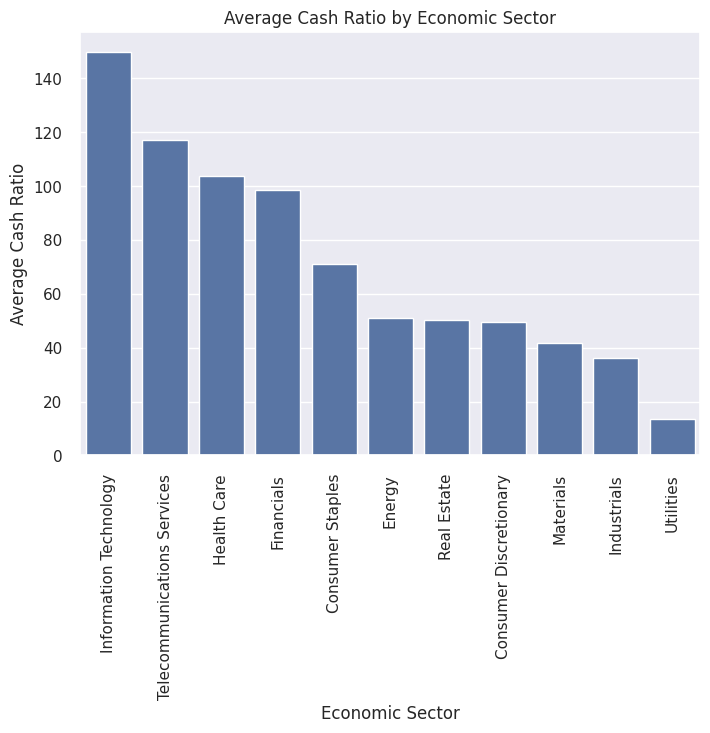

In [254]:
sns.barplot(data=sector_df.reset_index(), x='GICS Sector', y='Cash Ratio')
plt.xticks(rotation=90)
plt.title('Average Cash Ratio by Economic Sector')
plt.xlabel('Economic Sector')
plt.ylabel('Average Cash Ratio')

*  Information Technology has the highest average cash ratios followed by Telecommunication Services among all the sectors
* Utilities generates the lowest average cash ratios of all sectors

**P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?**

In [255]:
sector_df = stock.groupby('GICS Sector')['P/E Ratio'].mean().sort_values(ascending = False)
sector_df

,P/E Ratio
GICS Sector,
Energy,72.90
Information Technology,43.78
Real Estate,43.07
Health Care,41.14
Consumer Discretionary,35.21
Consumer Staples,25.52
Materials,24.59
Utilities,18.72
Industrials,18.26


Text(0, 0.5, 'Average P/E Ratio')

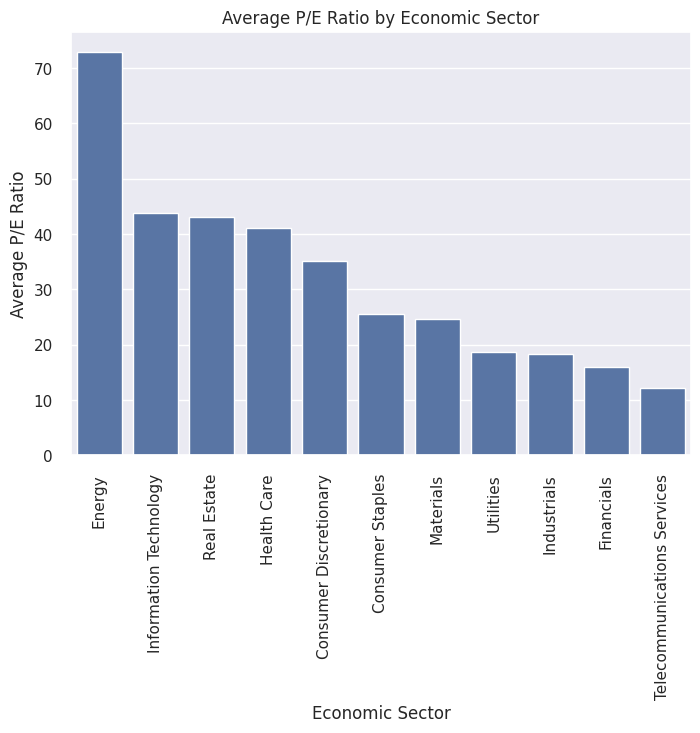

In [256]:
sns.barplot(data=sector_df.reset_index(), x='GICS Sector', y='P/E Ratio')
plt.xticks(rotation=90)
plt.title('Average P/E Ratio by Economic Sector')
plt.xlabel('Economic Sector')
plt.ylabel('Average P/E Ratio')

*  Energy companies have the highest average P/E ratios of all sectors by a considerable margin, with telecoms having the lowest average P/E ratios

**Volatility accounts for the fluctuation in the stock price. A stock with high volatility will witness sharper price changes, making it a riskier investment. Let's see how volatility varies, on average, across economic sectors.**

In [257]:
sector_df = stock.groupby('GICS Sector')['Volatility'].mean().sort_values(ascending = False)
sector_df

,Volatility
GICS Sector,
Energy,2.57
Materials,1.82
Information Technology,1.66
Consumer Discretionary,1.60
Health Care,1.54
Industrials,1.42
Telecommunications Services,1.34
Financials,1.27
Real Estate,1.21


Text(0, 0.5, 'Average Volatility')

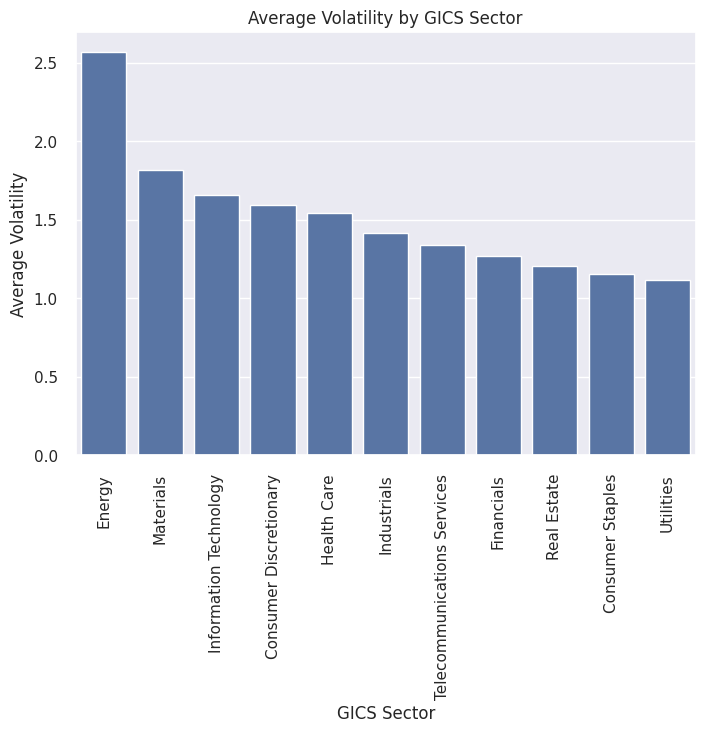

In [258]:
sns.barplot(data=sector_df.reset_index(), x='GICS Sector', y='Volatility')
plt.xticks(rotation=90)
plt.title('Average Volatility by GICS Sector')
plt.xlabel('GICS Sector')
plt.ylabel('Average Volatility')

Enerygy industry has the highest volatility of all sectors by a considerable margin

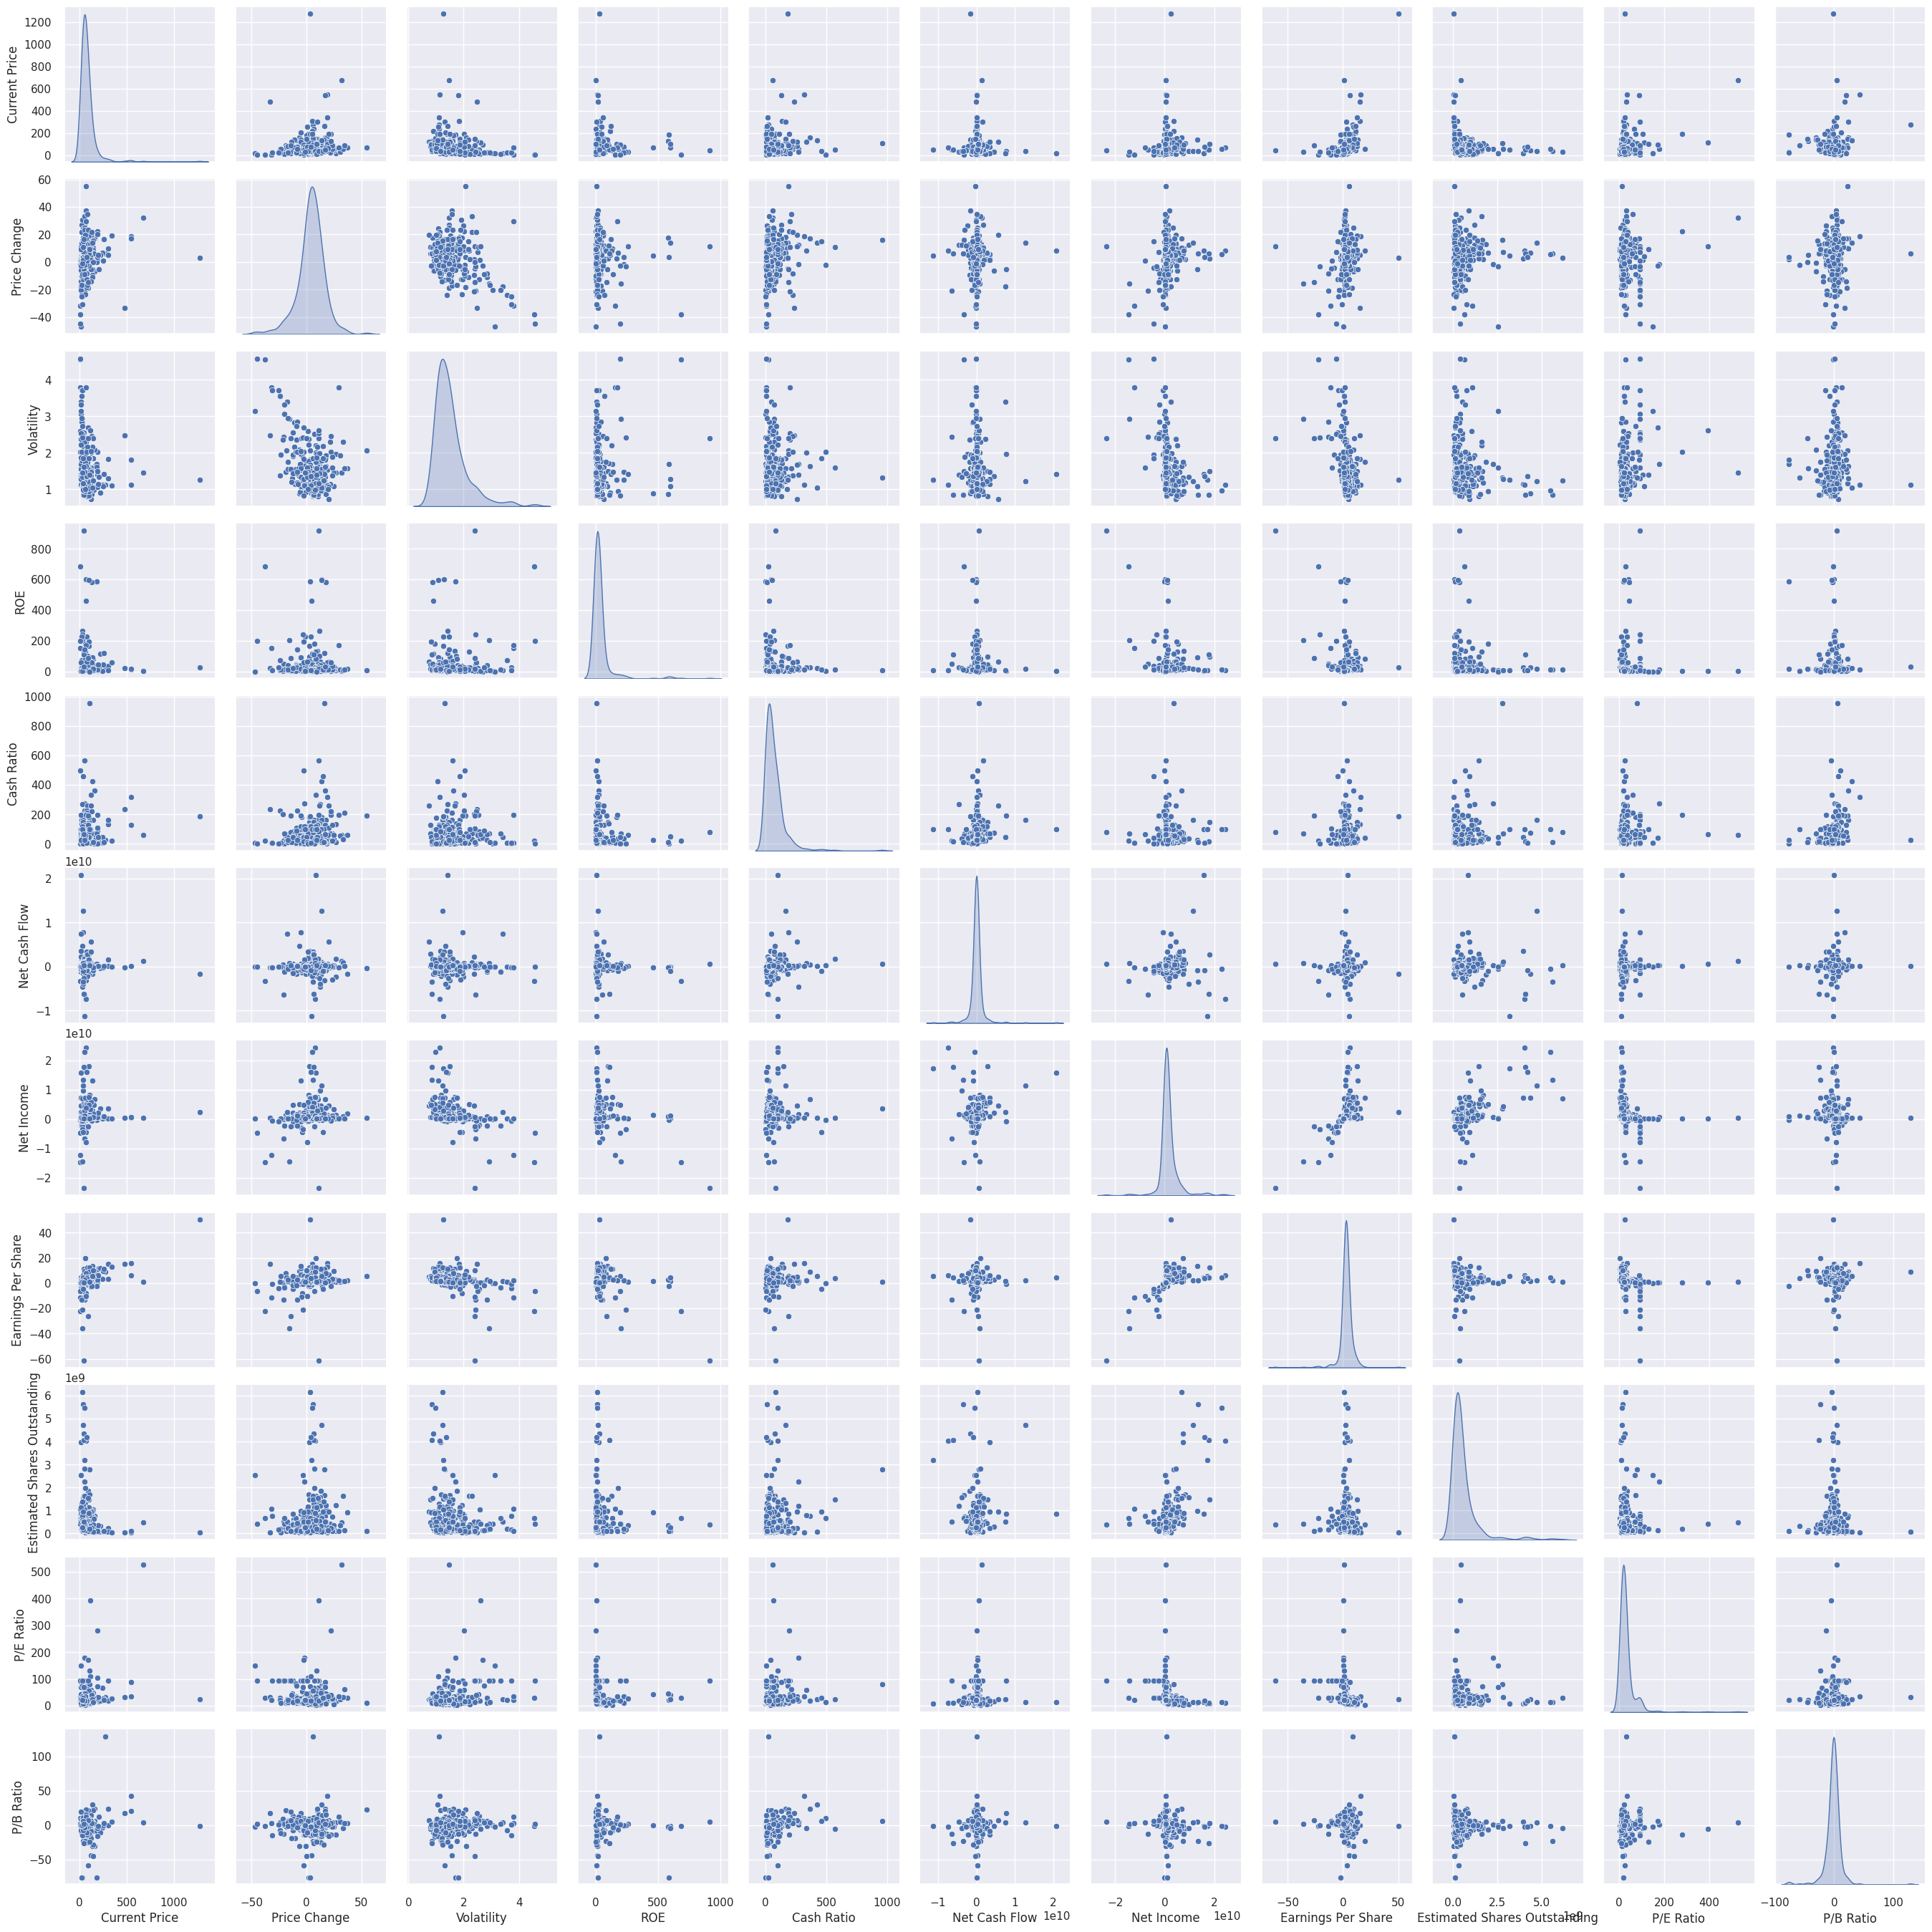

In [259]:
sns.pairplot(data=stock[num_cols], diag_kind="kde")
plt.show()

## Data Preprocessing

- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

In [260]:
# Drop Ticker Symbol since it is a unique identifier (same as 'Security')
stock.drop(['Ticker Symbol'], axis=1, inplace=True)

### Outlier Check

- Let's plot the boxplots of all numerical columns to check for outliers.

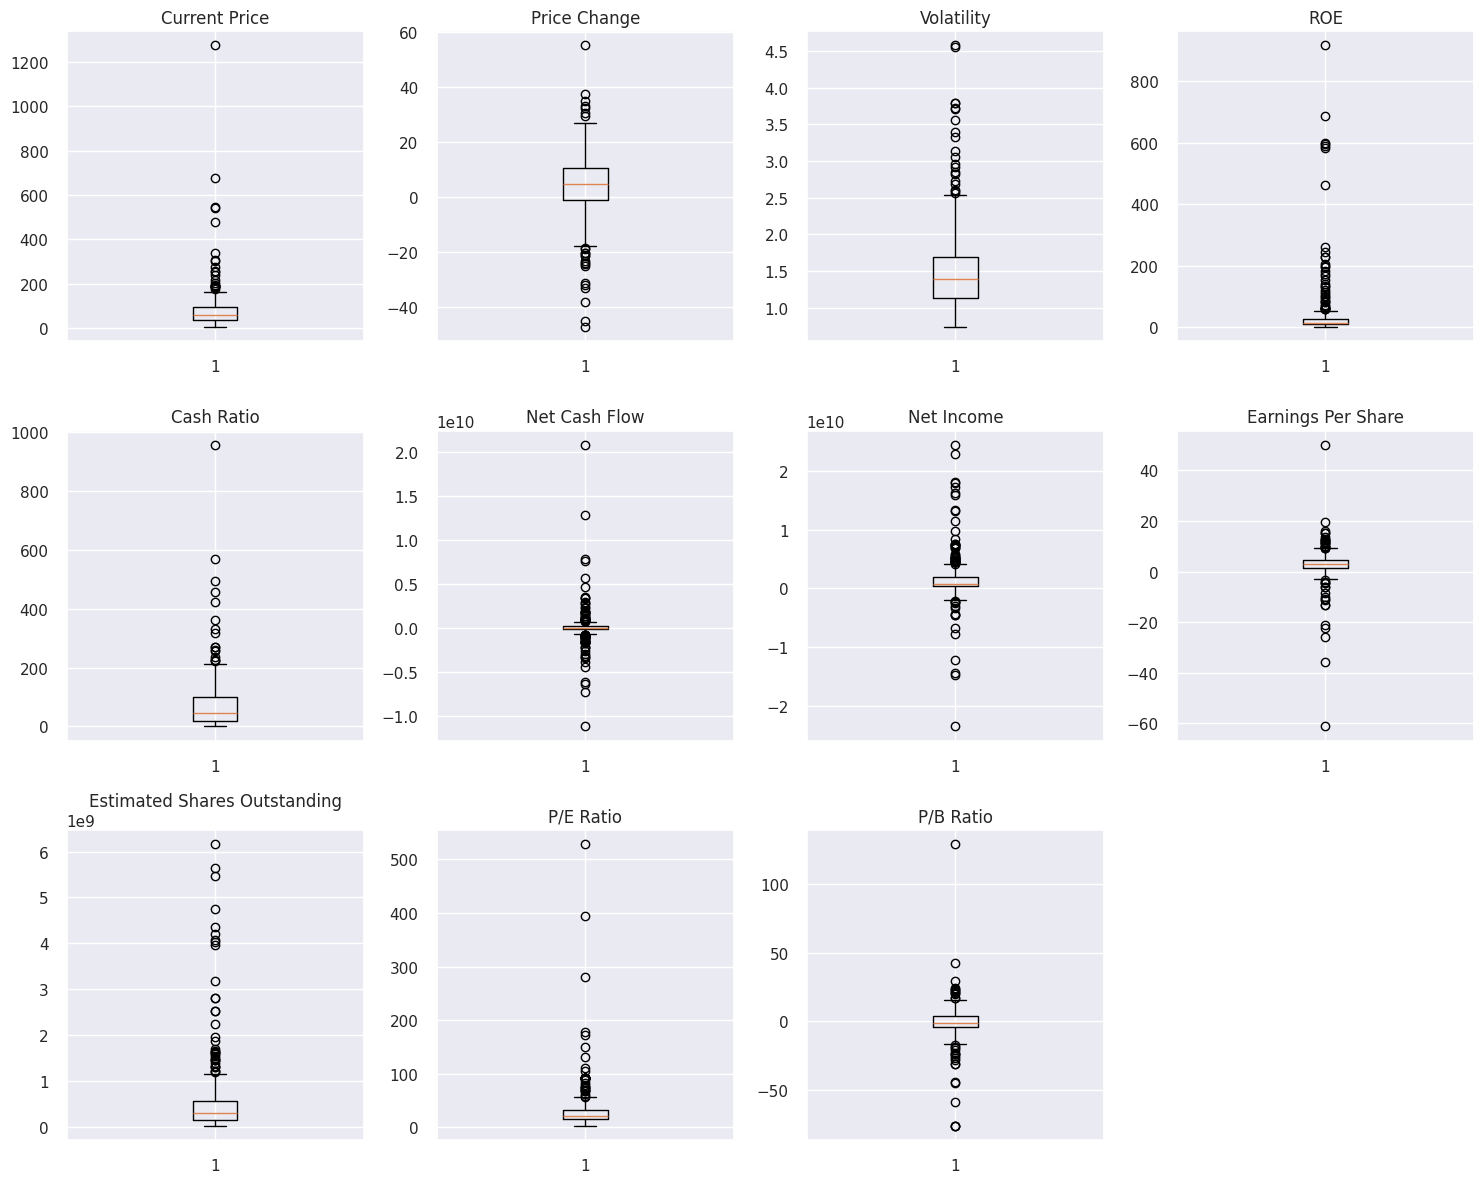

In [261]:
plt.figure(figsize=(15, 12))

numeric_columns = stock.select_dtypes(include=np.number).columns.tolist()

for i, variable in enumerate(numeric_columns):
    plt.subplot(3, 4, i + 1)
    plt.boxplot(stock[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

### Data Scaling

In [262]:
# variables used for clustering
num_cols

['Current Price',
 'Price Change',
 'Volatility',
 'ROE',
 'Cash Ratio',
 'Net Cash Flow',
 'Net Income',
 'Earnings Per Share',
 'Estimated Shares Outstanding',
 'P/E Ratio',
 'P/B Ratio']

In [263]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = stock[num_cols].copy()
subset_scaled = scaler.fit_transform(subset)

In [264]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

In [265]:
#Check the Scaled Dataframe
subset_scaled_df.head(10)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,-0.39,0.49,0.27,0.99,-0.21,-0.34,1.55,1.31,0.11,-0.65,-0.51
1,-0.22,0.36,1.14,0.94,0.08,-0.00,0.93,0.06,1.25,-0.31,-0.50
2,-0.37,0.60,-0.43,-0.19,-0.03,0.45,0.74,0.02,1.10,-0.39,0.09
3,0.13,0.83,-0.28,-0.32,1.22,-0.15,-0.22,-0.23,-0.09,0.95,0.42
4,-0.26,-0.49,0.30,-0.27,2.24,0.13,-0.20,-0.37,1.98,3.29,0.20
5,-0.45,-1.34,-0.02,-0.31,-0.23,-0.13,0.09,0.03,0.05,-0.46,0.66
6,2.00,0.18,-0.69,-0.10,-0.50,0.02,-0.23,0.93,-0.60,-0.04,9.38
7,-0.38,-0.16,-0.68,-0.32,-0.62,0.12,-0.22,-0.03,-0.39,-0.36,0.07
8,-0.23,-0.14,-0.77,-0.30,-0.68,-0.02,0.14,0.05,-0.18,-0.32,-0.09
9,-0.21,-0.09,-0.81,-0.27,0.32,-0.19,0.26,0.47,-0.17,-0.51,-0.01


###Post Preprocessing EDA

Outlier Investigation

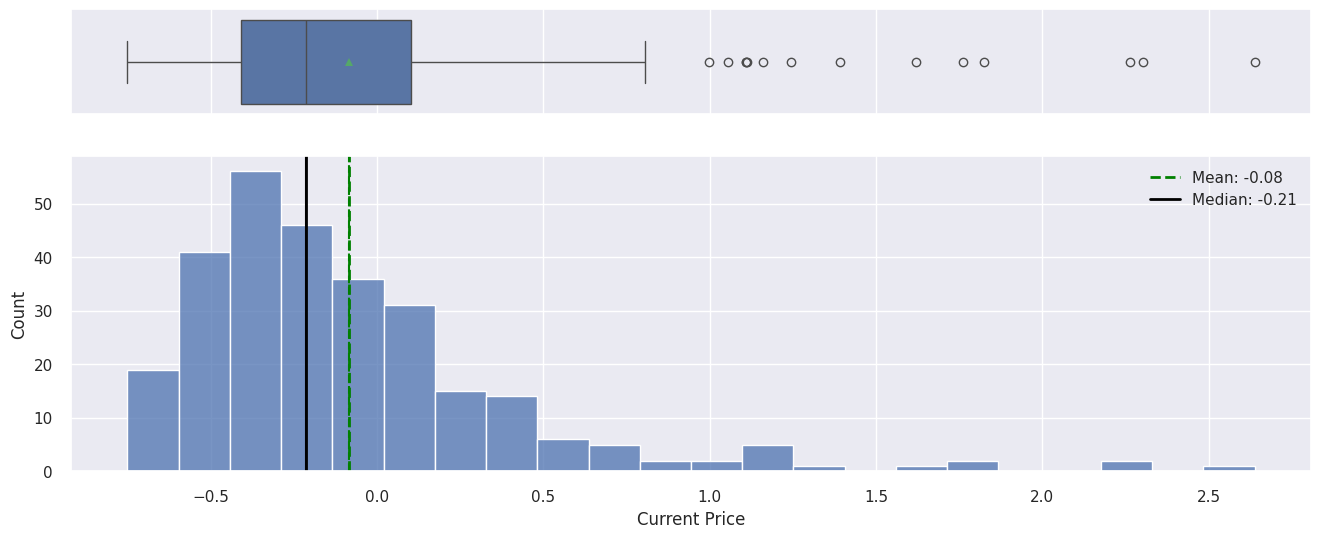

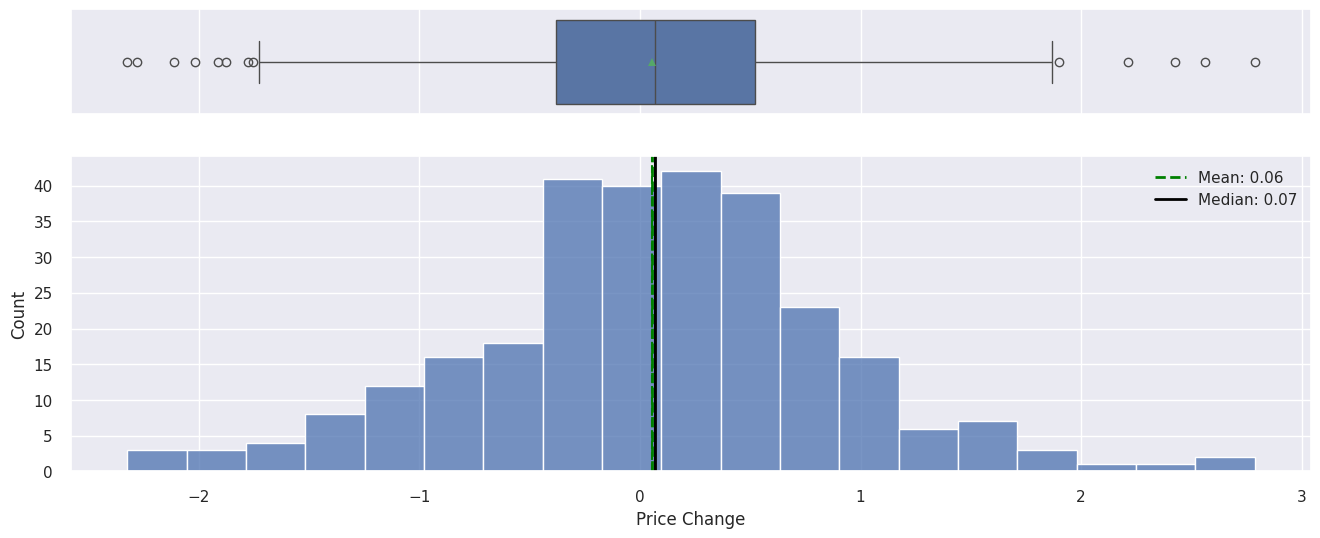

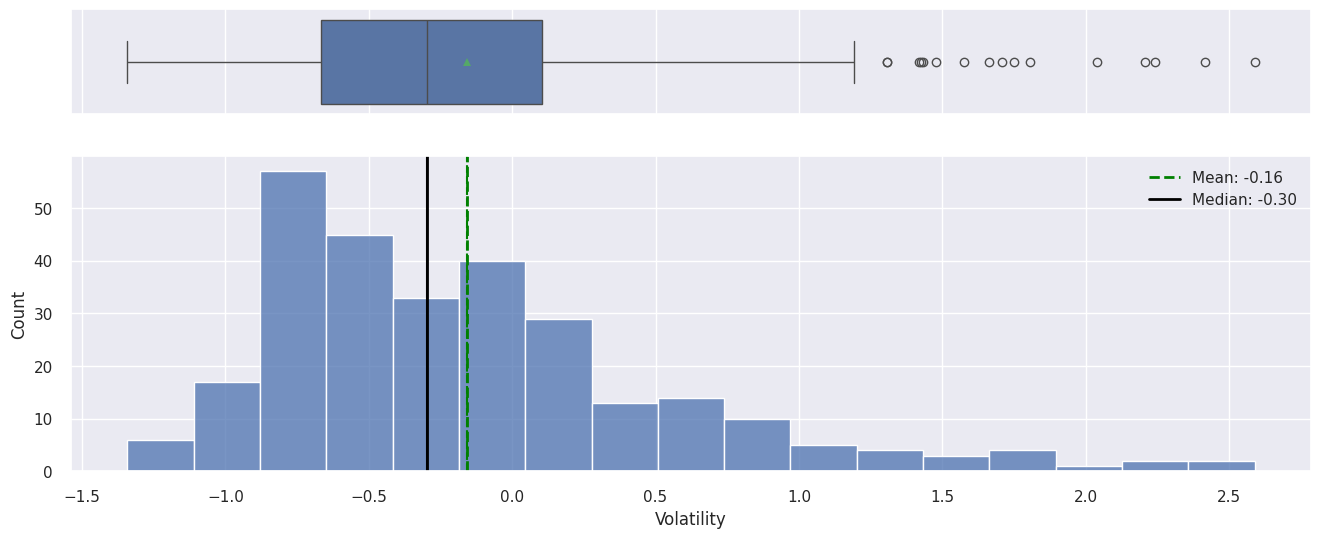

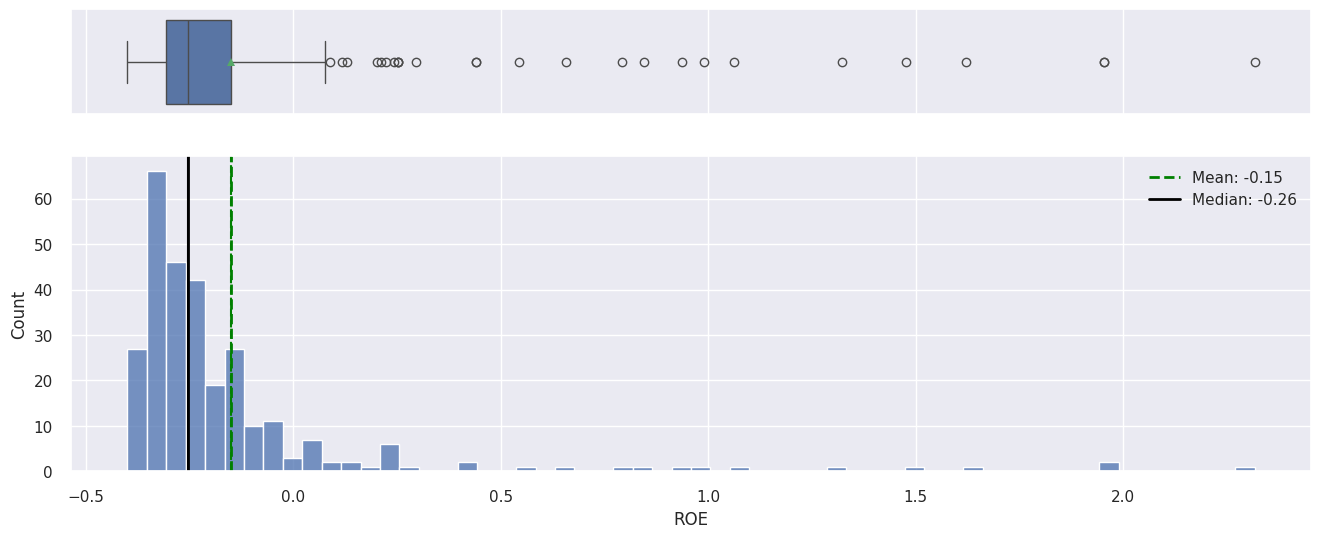

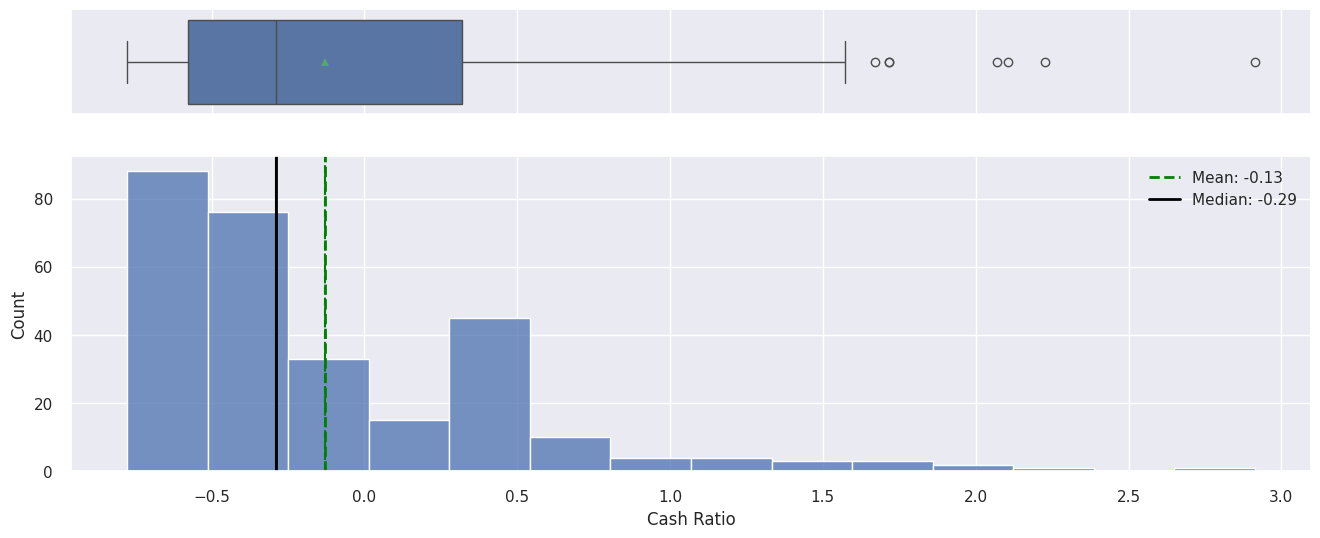

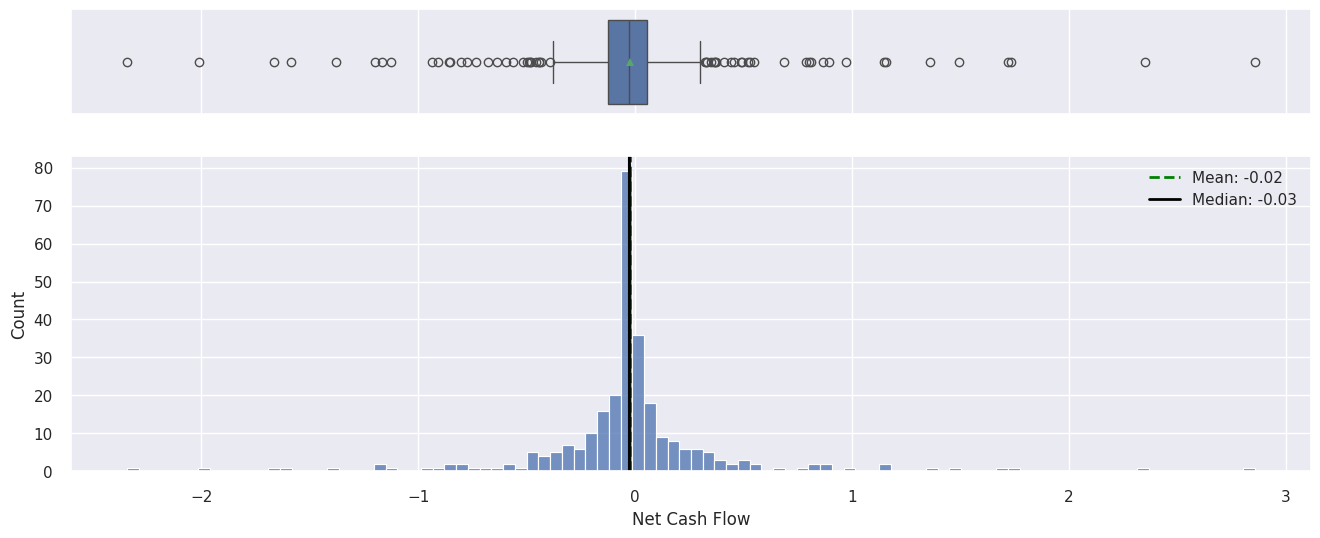

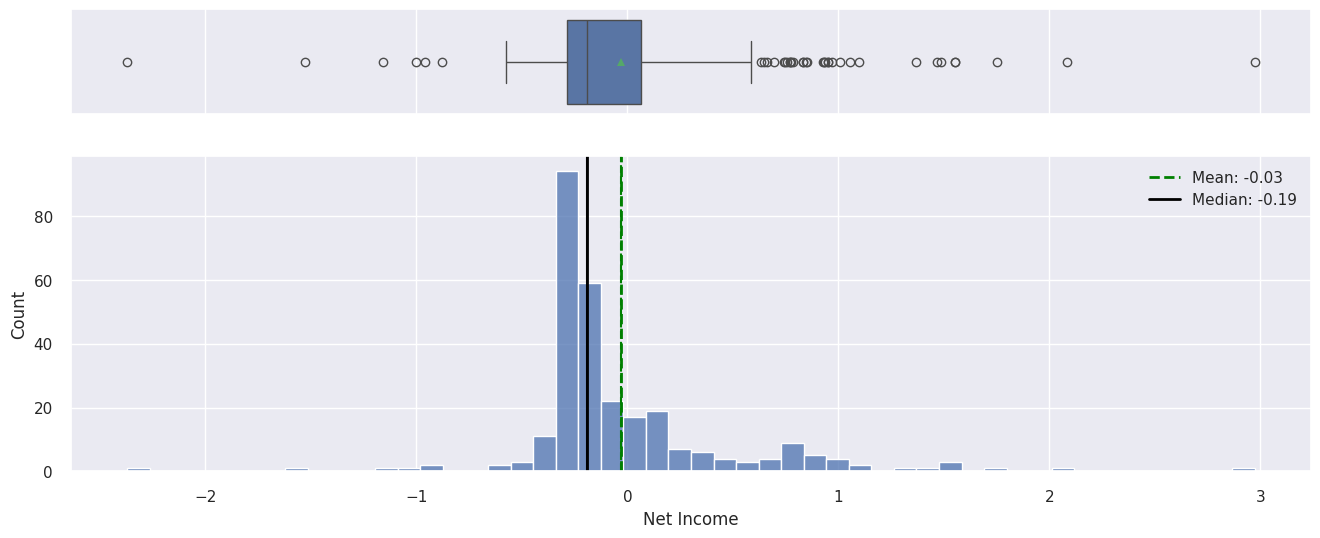

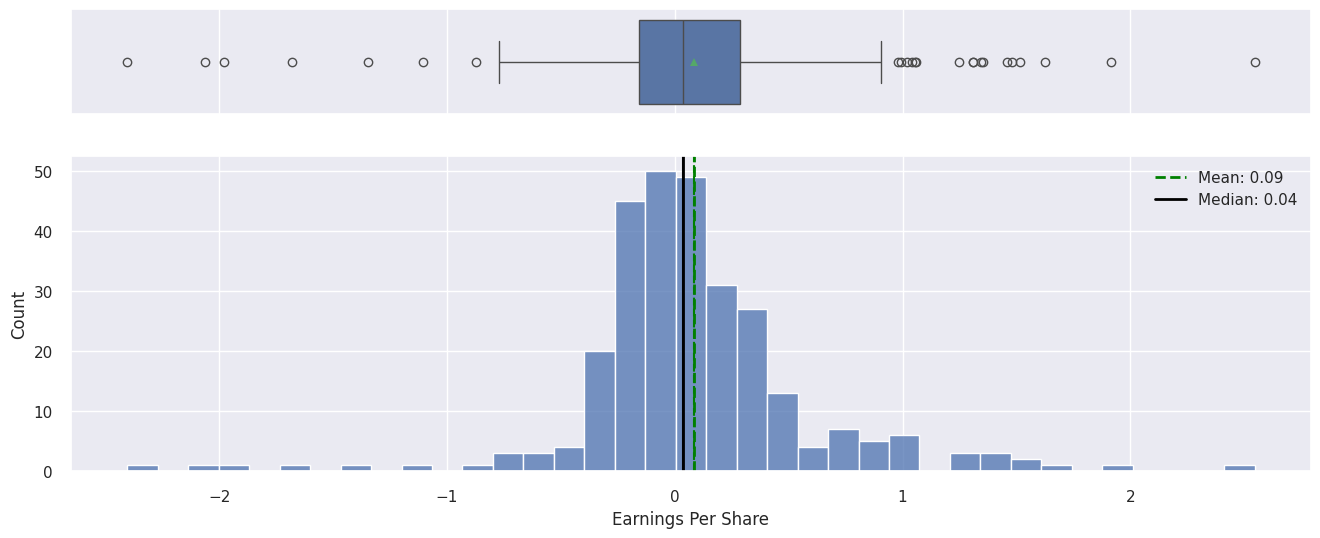

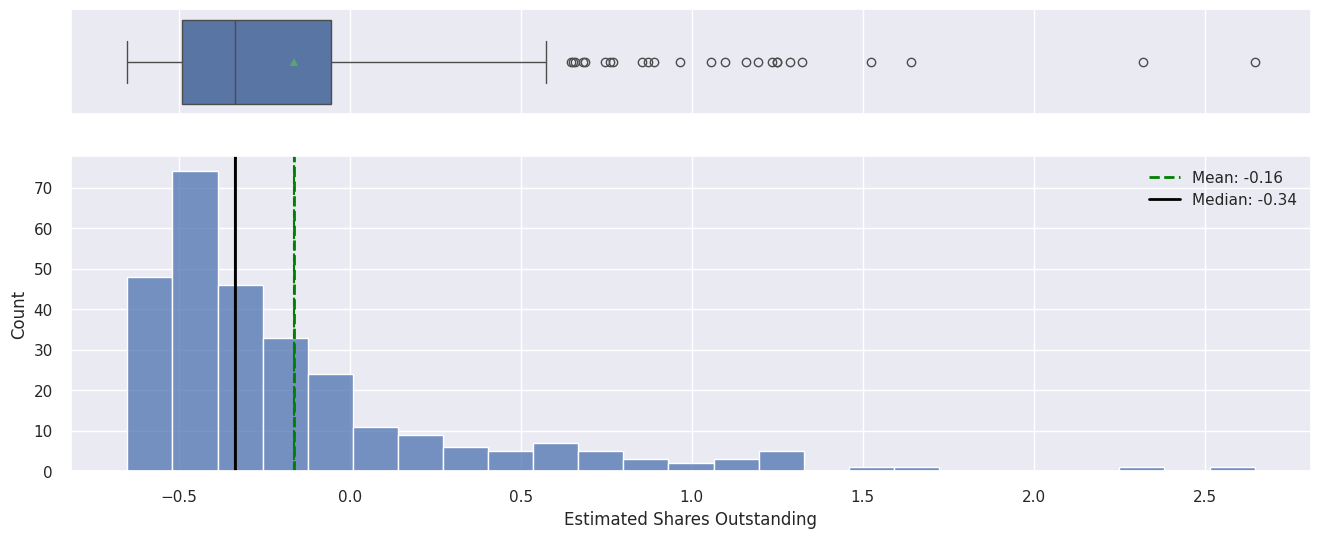

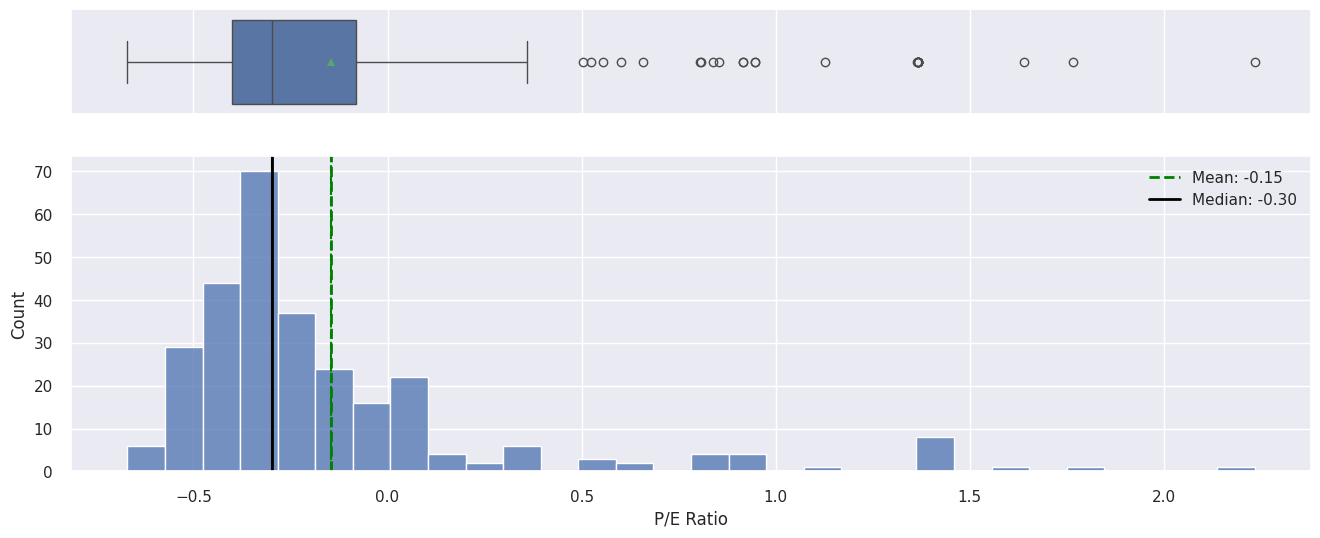

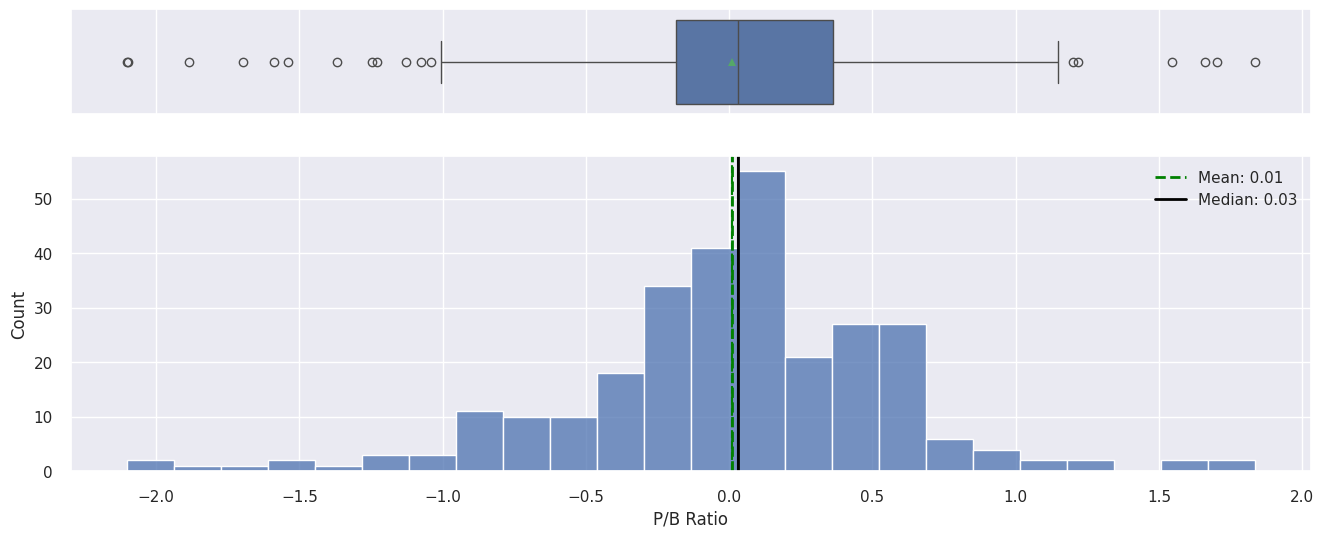

In [266]:
# Define a threshold to identify an outlier
threshold = 3

# Remove rows where any of the scaled values are greater than the absolute value of the threshold
df_no_outliers = subset_scaled_df[(np.abs(subset_scaled_df) < threshold).all(axis=1)]

# Plot all the numerical variables to check weather distribution is preserved
numerical_variables = [
    'Current Price',
    'Price Change',
    'Volatility',
    'ROE',
    'Cash Ratio',
    'Net Cash Flow',
    'Net Income',
    'Earnings Per Share',
    'Estimated Shares Outstanding',
    'P/E Ratio',
    'P/B Ratio'
    ]

    # Loop through the list and creating a histogram and boxplot for each variable
for variable in numerical_variables:
   histogram_boxplot(df_no_outliers, variable)

Observations:

*  It seems like the distribution and scewness of the data is retained even with the removal of the outliers, so it is safe to keep them.

## K-means Clustering

### Checking Elbow Plot

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.431736432420456
Number of Clusters: 3 	Average Distortion: 2.336484639062957
Number of Clusters: 4 	Average Distortion: 2.211205696720854
Number of Clusters: 5 	Average Distortion: 2.097334326296926
Number of Clusters: 6 	Average Distortion: 2.0809303903018552
Number of Clusters: 7 	Average Distortion: 1.9885150187709126
Number of Clusters: 8 	Average Distortion: 1.9508553918418279


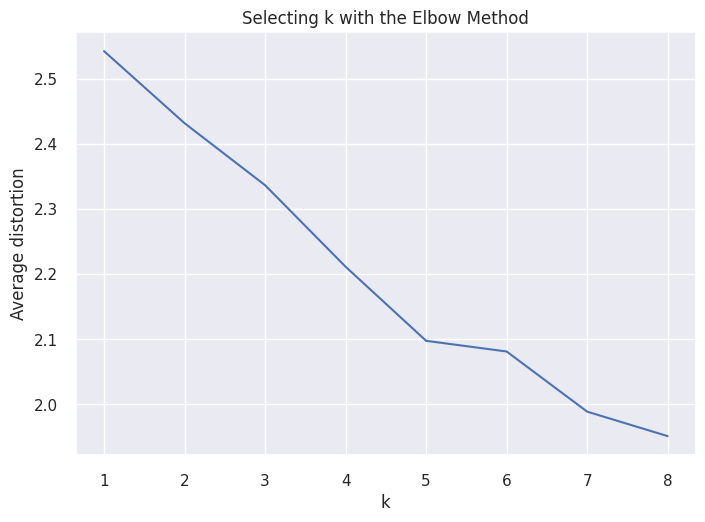

In [267]:
k_means_df = subset_scaled_df.copy()
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions)
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

**Appropriate value for k seems to be 5 or 6**

In [301]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1, 15), timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

Let's check the silhouette scores

For n_clusters = 2, the silhouette score is 0.4484662124740991)
For n_clusters = 3, the silhouette score is 0.4363128132485867)
For n_clusters = 4, the silhouette score is 0.43771006482776853)
For n_clusters = 5, the silhouette score is 0.42671394891063047)
For n_clusters = 6, the silhouette score is 0.07996043670136185)
For n_clusters = 7, the silhouette score is 0.34204611139396024)
For n_clusters = 8, the silhouette score is 0.22198491445702406)
For n_clusters = 9, the silhouette score is 0.1886263850551177)


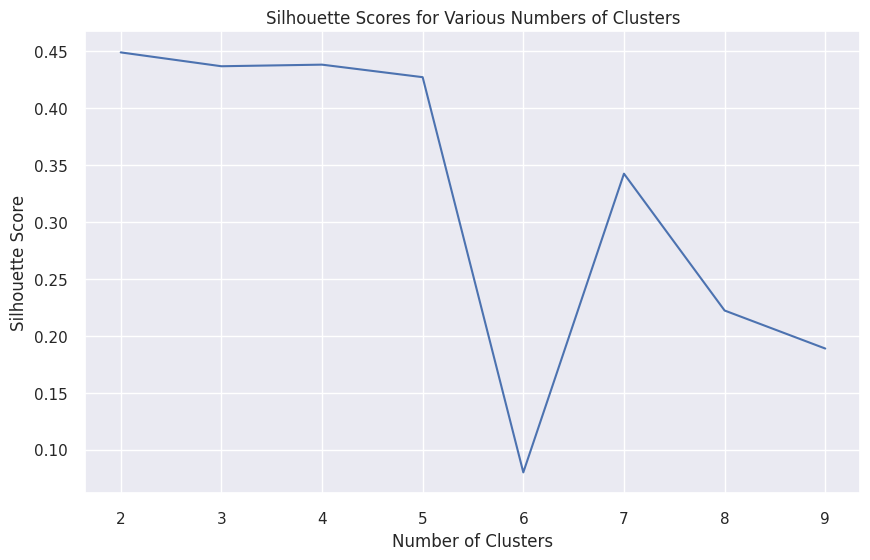

In [268]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_list, sil_score, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.show()

**Silhouette score for 5 is higher than that for 6. So, we will choose 5 as value of k.**

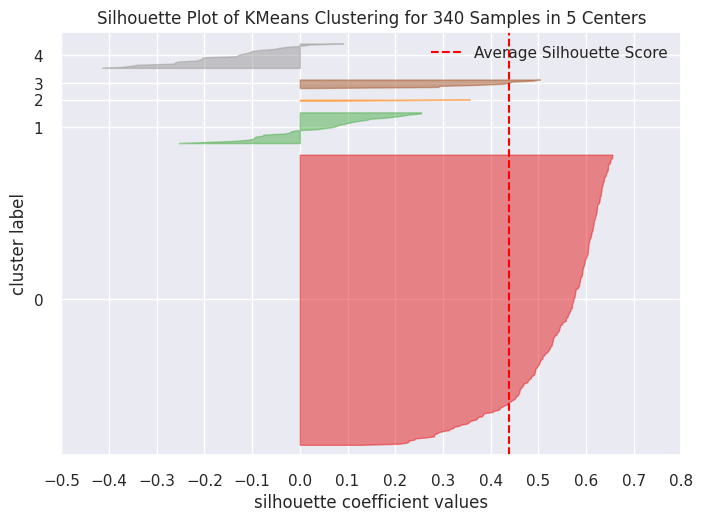

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 340 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [269]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

Observation

*  An average score that is moderate (closer to +0.5) or low (closer to 0 or negative) suggests that there might be considerable overlap among clusters or that points are not clearly defined within their clusters

Revisit the number of clusters chosen

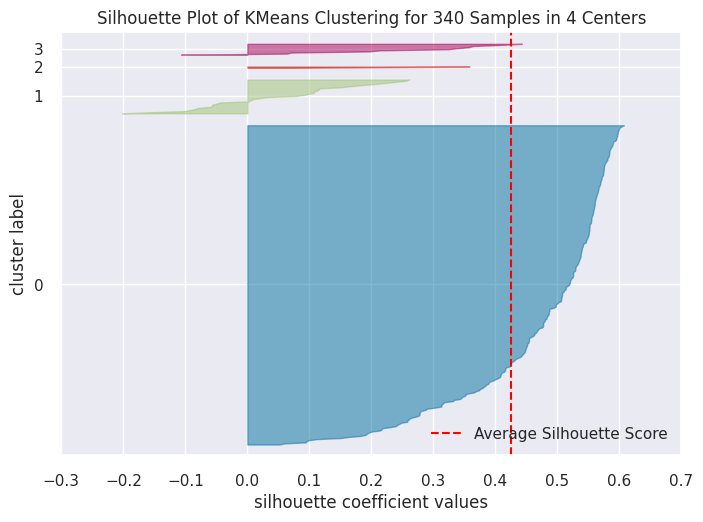

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 340 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [270]:
# finding optimal no. of clusters with silhouette coefficients with k=4
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1),colors='yellowbrick')
visualizer.fit(subset_scaled_df)
visualizer.show()

**With K =4,the average Silhouette is lower so we will go with k=5**

In [271]:
#To check the time
start_kmeans = time.time()

# let's take 5 as number of clusters
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(subset_scaled_df)

end_kmeans = time.time()
print("K-Means Time Taken: {:.4f} seconds".format(end_kmeans - start_kmeans))

K-Means Time Taken: 0.0053 seconds


In [272]:
# adding kmeans cluster labels to the original and scaled dataframes

stock["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_
stock.head(10)

,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments
0,American Airlines Group,Industrials,Airlines,42.35,10.00,1.69,135,51,-604000000,7610000000,11.39,668129938.50,3.72,-8.78,0
1,AbbVie,Health Care,Pharmaceuticals,59.24,8.34,2.20,130,77,51000000,5144000000,3.15,1633015873.00,18.81,-8.75,0
2,Abbott Laboratories,Health Care,Health Care Equipment,44.91,11.30,1.27,21,67,938000000,4423000000,2.94,1504421769.00,15.28,-0.39,0
3,Adobe Systems Inc,Information Technology,Application Software,93.94,13.98,1.36,9,180,-240840000,629551000,1.26,499643650.80,74.56,4.20,0
4,"Analog Devices, Inc.",Information Technology,Semiconductors,55.32,-1.83,1.70,14,272,315120000,696878000,0.31,2247993548.00,178.45,1.06,1
5,Archer-Daniels-Midland Co,Consumer Staples,Agricultural Products,36.68,-12.02,1.52,10,49,-189000000,1849000000,2.99,618394648.80,12.27,7.50,0
6,Alliance Data Systems,Information Technology,Data Processing & Outsourced Services,276.57,6.19,1.12,30,25,90885000,596541000,8.91,66951851.85,31.04,129.06,4
7,Ameren Corp,Utilities,MultiUtilities,43.23,2.17,1.12,9,14,287000000,636000000,2.60,244615384.60,16.63,-0.72,0
8,American Electric Power,Utilities,Electric Utilities,58.27,2.37,1.07,11,9,13900000,2052300000,3.13,421897810.20,18.46,-3.02,0
9,AFLAC Inc,Financials,Life & Health Insurance,59.90,3.03,1.05,14,99,-308000000,2533000000,5.88,430782312.90,10.19,-1.88,0


###Print the name of the companies in each cluster

In [273]:
# print the names of the companies in each cluster
for cl in stock["K_means_segments"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(stock[stock["K_means_segments"] == cl]["Security"].unique().tolist())
    print()

In cluster 0, the following companies are present:
['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Adobe Systems Inc', 'Archer-Daniels-Midland Co', 'Ameren Corp', 'American Electric Power', 'AFLAC Inc', 'American International Group, Inc.', 'Apartment Investment & Mgmt', 'Assurant Inc', 'Arthur J. Gallagher & Co.', 'Akamai Technologies Inc', 'Albemarle Corp', 'Alaska Air Group Inc', 'Allstate Corp', 'Allegion', 'Applied Materials Inc', 'AMETEK Inc', 'Affiliated Managers Group Inc', 'Ameriprise Financial', 'American Tower Corp A', 'AutoNation Inc', 'Anthem Inc.', 'Aon plc', 'Amphenol Corp', 'Arconic Inc', 'Activision Blizzard', 'AvalonBay Communities, Inc.', 'Broadcom', 'American Water Works Company Inc', 'American Express Co', 'Boeing Company', 'Baxter International Inc.', 'BB&T Corporation', 'Bard (C.R.) Inc.', 'The Bank of New York Mellon Corp.', 'Ball Corp', 'Bristol-Myers Squibb', 'Boston Scientific', 'BorgWarner', 'Boston Properties', 'Caterpillar Inc.', 'Chubb Limit

In [274]:
#print number of stocks within each sector for all of the clusters
for k in range(0,stock['K_means_segments'].nunique()):
    print('The number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(stock[stock['K_means_segments']==k]['GICS Sector'].value_counts())
    print("   ")

The number of stocks within each GICS Sector for Cluster 0 are:
GICS Sector
Industrials                    52
Financials                     45
Consumer Discretionary         33
Health Care                    29
Real Estate                    26
Information Technology         24
Utilities                      24
Materials                      18
Consumer Staples               17
Energy                          5
Telecommunications Services     2
Name: count, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
GICS Sector
Energy                    21
Information Technology     4
Materials                  2
Health Care                1
Consumer Discretionary     1
Industrials                1
Name: count, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:
GICS Sector
Energy    2
Name: count, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 3 are:
GICS Sector
Financials                     3
Telecommunica

## Cluster Profiling

In [275]:
cluster_profile = stock.groupby("K_means_segments")[num_cols].mean()

In [276]:
cluster_profile["count_in_each_segments"] = (
    stock.groupby("K_means_segments")["Current Price"].count().values
)

In [277]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,count_in_each_segments
K_means_segments,,,,,,,,,,,,
0,72.738269,5.179897,1.380738,34.825455,53.138182,-10147287.272727,1488641570.909091,3.636164,437961614.918582,23.680917,-3.395254,275
1,65.106668,-11.888125,2.722141,44.000000,61.400000,-36858300.000000,-2137169366.666667,-5.560333,529714171.048000,113.488924,0.905486,30
2,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2
3,46.672222,5.166566,1.079367,25.000000,58.333333,-3040666666.666667,14848444444.444445,3.435556,4564959946.222222,15.596051,-6.354193,9
4,211.164720,12.456786,1.699388,30.708333,280.250000,2197085166.666667,2808600583.333333,6.818333,738957421.659167,37.895420,15.682619,24


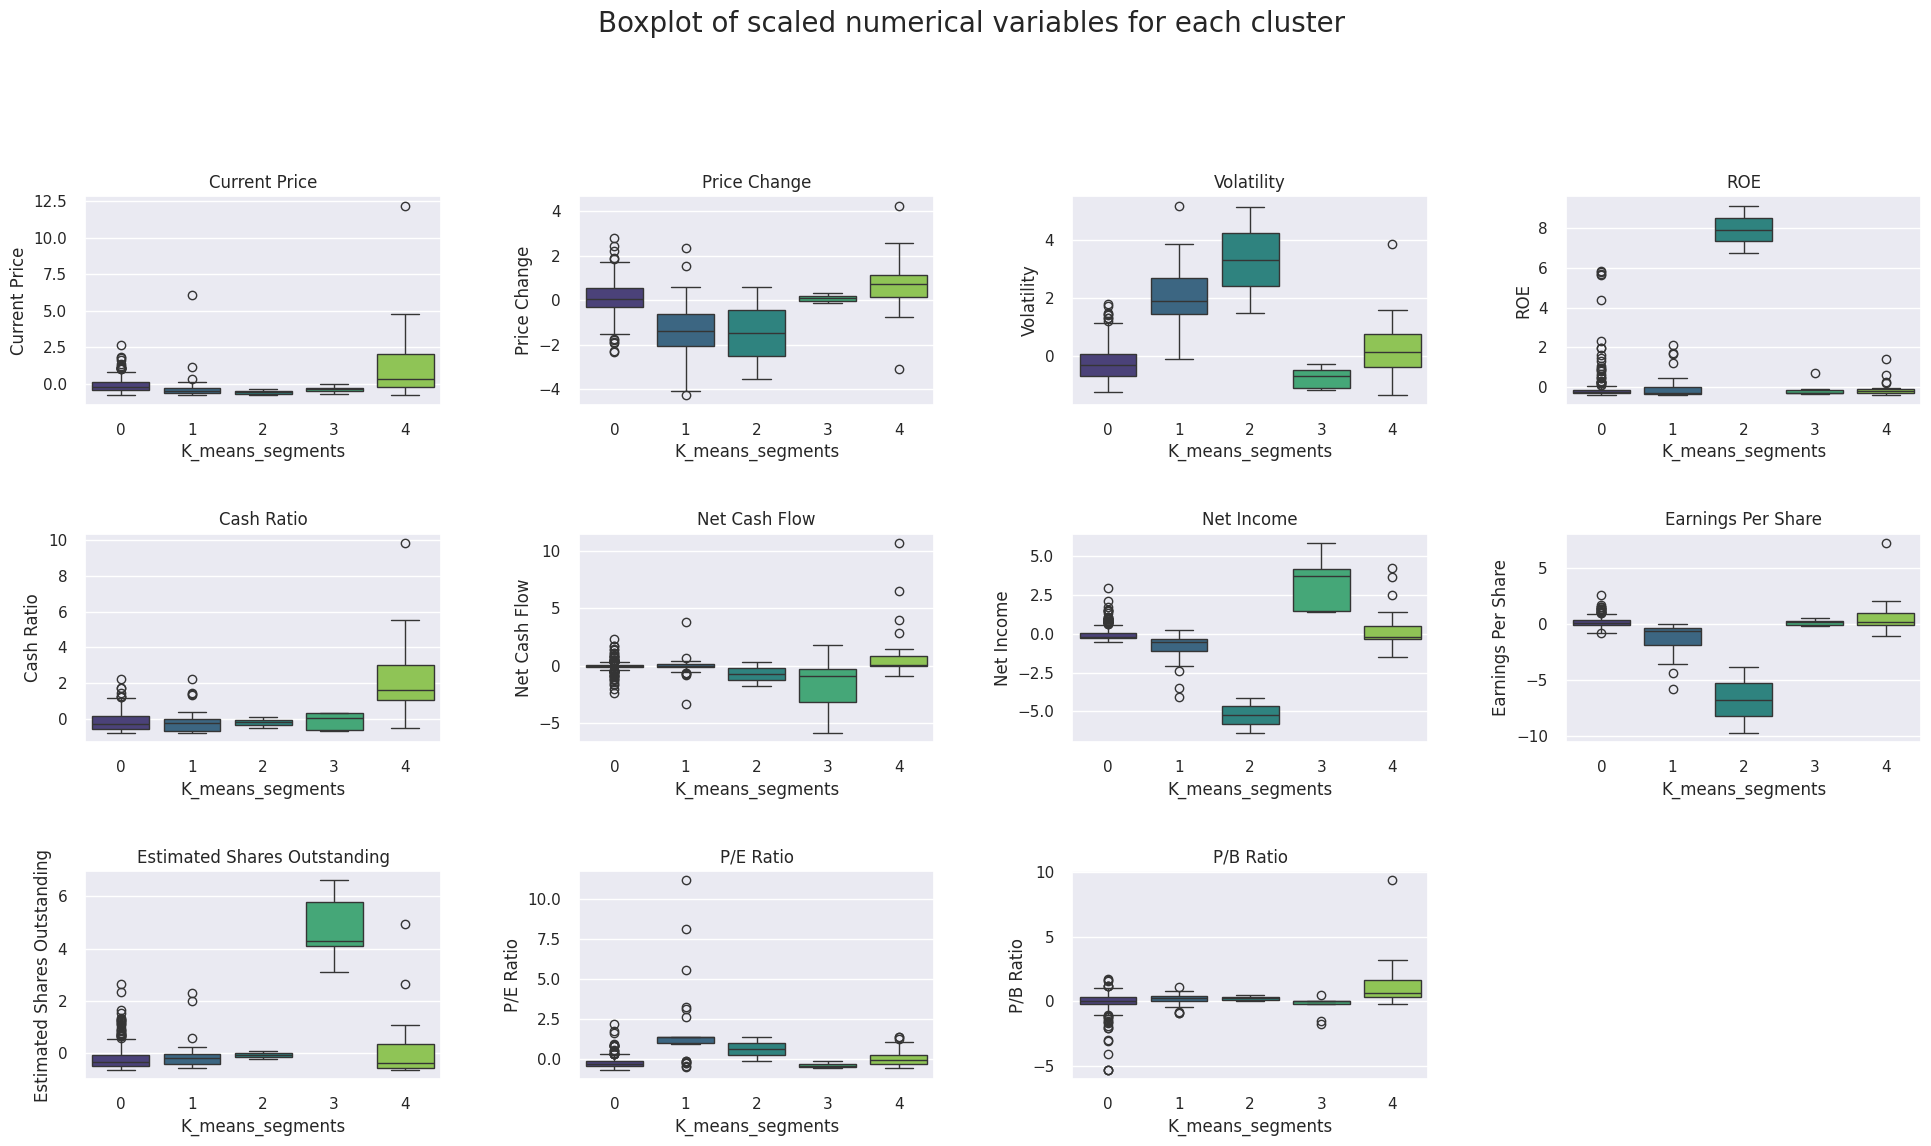

In [278]:

fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # 3 rows, 4 columns
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)

axes = axes.flatten()  # Flatten the 2D array of axes into 1D

for i in range(len(num_cols)):
    sns.boxplot(
        ax=axes[i],
        y=subset_scaled_df[num_cols[i]],
        x=subset_scaled_df["K_means_segments"],
        palette="viridis"
    )
    axes[i].set_title(num_cols[i])

# Hide any unused axes (e.g., the 12th one if only 11 plots)
for j in range(len(num_cols), len(axes)):
    axes[j].set_visible(False)
fig.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap with suptitle



In [279]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,count_in_each_segments
K_means_segments,,,,,,,,,,,,
0,72.738269,5.179897,1.380738,34.825455,53.138182,-10147287.272727,1488641570.909091,3.636164,437961614.918582,23.680917,-3.395254,275
1,65.106668,-11.888125,2.722141,44.000000,61.400000,-36858300.000000,-2137169366.666667,-5.560333,529714171.048000,113.488924,0.905486,30
2,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2
3,46.672222,5.166566,1.079367,25.000000,58.333333,-3040666666.666667,14848444444.444445,3.435556,4564959946.222222,15.596051,-6.354193,9
4,211.164720,12.456786,1.699388,30.708333,280.250000,2197085166.666667,2808600583.333333,6.818333,738957421.659167,37.895420,15.682619,24


## Insights

- **Cluster 0**:
    - 24 stocks comprised of stocks under Information Technology,Health Care and
Consumer Discretionary sector
    - Cluster 0 stocks have the highest Current Price,Price Change,Cash Ratio,Earnings per share,P/B Ratio
    - High Current Price + Price Change suggest the Investors are confident.Price are high and rising as these stocks may be trending or experiencing a strong demand
    - High EPS shows :These companies are earning well
    - High Cash Ratio shows theay have plenty of cash liquidity to cover short term obligations
    -The high P/B might also be a red flag for being potentially overpriced.
    - In short it can be said that stocks in this cluster 0 is well performing and blong to growth oriented companies
   
- **Cluster 1**:
    - 34 stocks comprised mostly of stocks under Industrials,Consumer Staples ,
Financials,Health Care,Consumer Discretionary sector   
    - Cluster 1 stocks have the highest Net income and highest Estimated shares outstanding
    - Highest Net Income means these hese companies are making the most total profit
    - Highest Estimated shares outstanding means these companies in these clusters have a large number of shares issued ie heavily traded in the market
    
- **Cluster 2**:
    - 1 stock belonging to the Energy sector
    - The only stock in Cluster 2 has the highest ROE and Net Cash flow
    - This cluster has negative net income
    - In short it is cash rich but unprofitable

- **Cluster 3**:
    - 253 stocks(almost 74% of stocks in the dataset) comprised mostly of stocks under the sectors Industrials,Financials,Consumer Discretionary.HealthCare
  
    - Low volatility (1.40) — price is not swinging much

    * Positive net income (1.16B) — the company is technically profitable

  * Decent EPS (3.48) — shareholders are earning something

  * Reasonable P/E (23.9) — fairly valued, not overbought
  * Net Cash Flow is negative

- **Cluster 4**:
    - 28 stock most of them belonging to the Energy sector
    - Volatility: 2.85 ( Highest risk)

    *Price Change: -13.27% (Negative trend)

  * Net Income: -2.88B (Heavy losses)

  * EPS: -6.87 (Unprofitable)

 * P/E Ratio: 112.93 (Very high — likely overvalued )   

## Hierarchical Clustering

### Computing Cophenetic Correlation

In [280]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9381866862278843.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8741250189456776.
Cophenetic correlation for Euclidean distance and average linkage is 0.9501078999418133.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8950437139160046.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9327825401743682.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8238581136070481.
Cophenetic correlation for Chebyshev distance and average linkage is 0.941660816516849.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8974299860845545.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9375736709363667.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.8440553871479906.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9405496499144259.
Cophenetic cor

In [281]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9501078999418133, which is obtained with Euclidean distance and average linkage.


Let's explore different linkage methods with Euclidean distance only.

In [282]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.9381866862278843.
Cophenetic correlation for complete linkage is 0.8741250189456776.
Cophenetic correlation for average linkage is 0.9501078999418133.
Cophenetic correlation for centroid linkage is 0.9488456422293653.
Cophenetic correlation for ward linkage is 0.7796428374975963.
Cophenetic correlation for weighted linkage is 0.8950437139160046.


In [283]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9501078999418133, which is obtained with average linkage.


We see that the cophenetic correlation is maximum with Euclidean distance and centroid linkage.

Let's see the dendrograms for the different linkage methods.

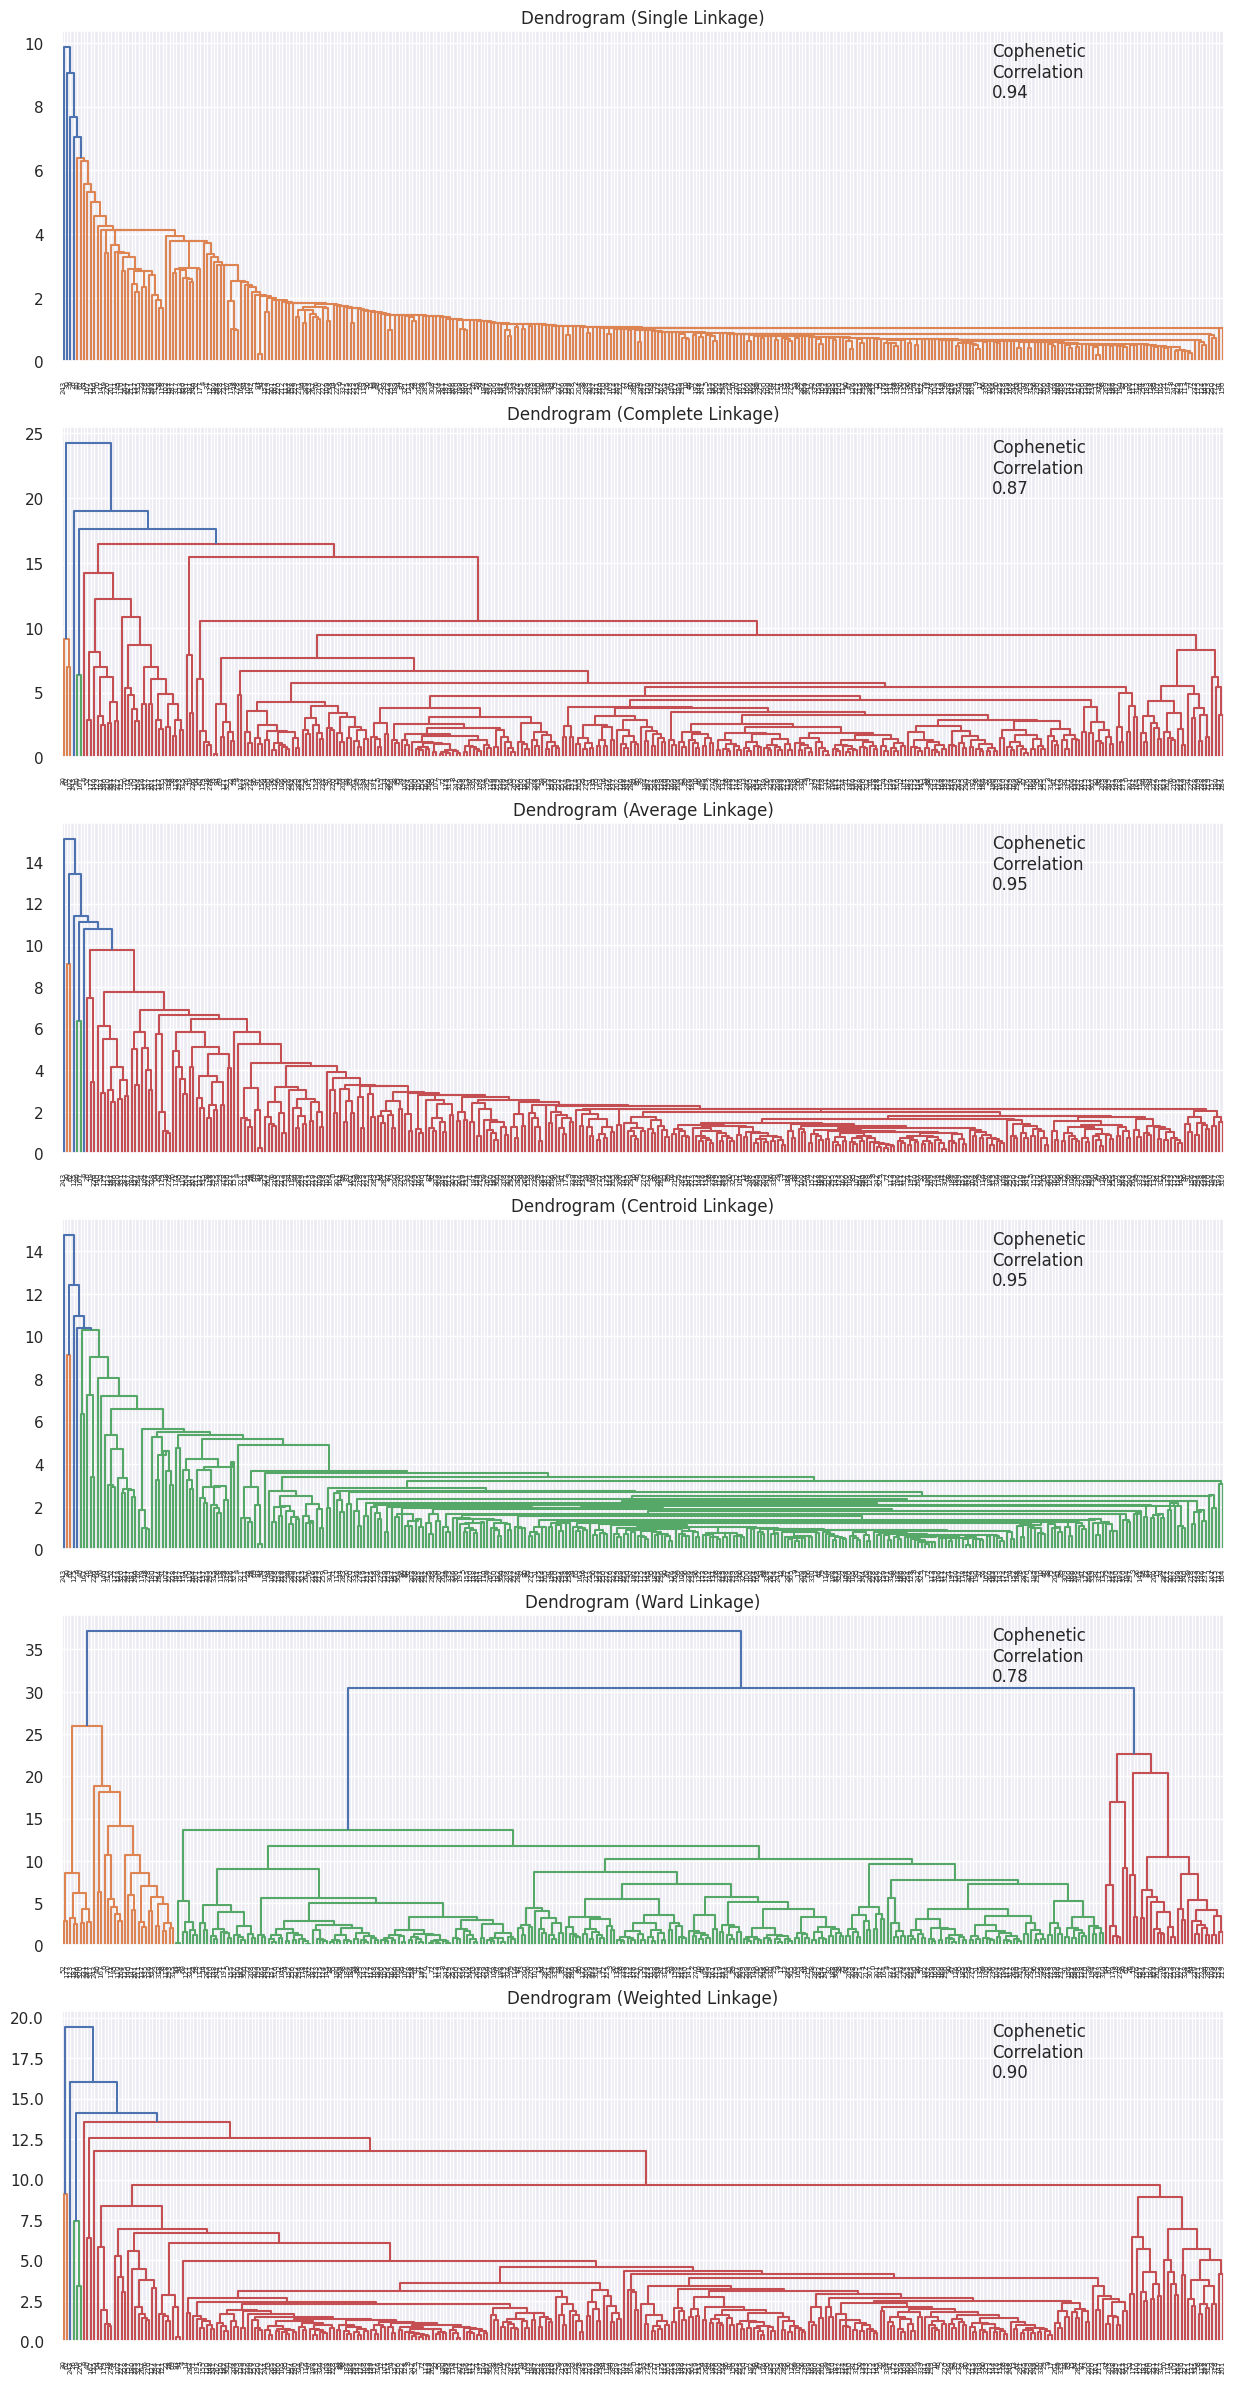

In [284]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

**Observations**

* The cophenetic correlation is highest for average and centroid linkage methods, but the dendrogram for average appears to provide better clusters

* But the dendrogram for Ward linkage gave us separate and distinct clusters,so we can check that too

###Determining the number of clusters using Silhouette score

**With Linkage = "Ward"**

In [285]:
range_n_clusters = range(2, 6)
sil_scores = []

for n_clusters in range_n_clusters:
    model = AgglomerativeClustering(n_clusters=n_clusters,metric="euclidean", linkage="ward")
    labels = model.fit_predict(subset_scaled_df)
    score = silhouette_score(subset_scaled_df, labels)
    sil_scores.append(score)
    print(f"n_clusters = {n_clusters} => Silhouette Score = {score:.4f}")


n_clusters = 2 => Silhouette Score = 0.5395
n_clusters = 3 => Silhouette Score = 0.4737
n_clusters = 4 => Silhouette Score = 0.4897
n_clusters = 5 => Silhouette Score = 0.4724


We will choose the n_clusters as 4  for hierarchial clustering  with 'ward' linkage as 2 is very small number

**With Linkage = "Average"**

In [286]:
range_n_clusters = range(2, 6)
sil_scores = []

for n_clusters in range_n_clusters:
    model = AgglomerativeClustering(n_clusters=n_clusters,metric="euclidean", linkage="average")
    labels = model.fit_predict(subset_scaled_df)
    score = silhouette_score(subset_scaled_df, labels)
    sil_scores.append(score)
    print(f"n_clusters = {n_clusters} => Silhouette Score = {score:.4f}")


n_clusters = 2 => Silhouette Score = 0.7354
n_clusters = 3 => Silhouette Score = 0.7029
n_clusters = 4 => Silhouette Score = 0.6481
n_clusters = 5 => Silhouette Score = 0.6394


We will choose the n_clusters as 3  for hierarchial clustering  with 'average' linkage as 2 is very small number

###Hierarchial Clustering with "average linkage"

In [287]:
# --- Hierarchical with timing ---
start_hc = time.time()

HCmodel = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

end_hc = time.time()
print("Hierarchical Clustering with average linkage Time Taken: {:.4f} seconds".format(end_hc - start_hc))


Hierarchical Clustering with average linkage Time Taken: 0.0110 seconds


In [288]:
# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_df["HC_Clusters"] = HCmodel.labels_
stock["HC_Clusters"] = HCmodel.labels_

###Cluster Profiling

In [289]:
cluster_profile = stock.groupby("HC_Clusters")[num_cols].mean()

In [290]:
cluster_profile["count_in_each_segments"] = (
    stock.groupby("HC_Clusters")["Current Price"].count().values
)

In [291]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,count_in_each_segments
HC_Clusters,,,,,,,,,,,,
0,77.573266,4.148438,1.515708,35.184524,67.154762,67104693.452381,1607391086.309524,2.905640,572317821.413095,32.325679,-1.762402,336
1,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,1
2,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2
3,104.660004,16.224320,1.320606,8.000000,958.000000,592000000.000000,3669000000.000000,1.310000,2800763359.000000,79.893133,5.884467,1


**Such an imbalanced distribution of (336,1,2,1) suggests that the clustering algorithm isn't segmenting the data well.**

* So we will try with linkage ='ward' too to see whether it provides better clustering

###Hierarchial clustering with linkage = 'ward'

In [292]:
# --- Hierarchical with timing ---
start_hc = time.time()

HCmodel = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

end_hc = time.time()
print("Hierarchical Clustering with ward linkage Time Taken: {:.4f} seconds".format(end_hc - start_hc))

Hierarchical Clustering with ward linkage Time Taken: 0.0089 seconds


In [293]:
# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_df["HC_Clusters"] = HCmodel.labels_
stock["HC_Clusters"] = HCmodel.labels_

cluster_profile1 = stock.groupby("HC_Clusters")[num_cols].mean()

In [294]:
cluster_profile1["count_in_each_segments"] = (
    stock.groupby("HC_Clusters")["Current Price"].count().values
)

In [295]:
# let's display cluster profiles
cluster_profile1.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,count_in_each_segments
HC_Clusters,,,,,,,,,,,,
0,69.606858,-8.759350,2.582625,163.971429,45.828571,-169242057.142857,-2847835142.857143,-6.959143,465100679.061143,97.974818,-1.845420,35
1,211.164720,12.456786,1.699388,30.708333,280.250000,2197085166.666667,2808600583.333333,6.818333,738957421.659167,37.895420,15.682619,24
2,71.944683,4.954784,1.389487,24.860294,54.974265,-2050665.441176,1495303606.617647,3.651011,445189314.093419,24.298891,-3.083861,272
3,46.672222,5.166566,1.079367,25.000000,58.333333,-3040666666.666667,14848444444.444445,3.435556,4564959946.222222,15.596051,-6.354193,9


So hierarchial clustering with linkage =ward is prefereed more as:

* Not overly dominated by one giant cluster.

* Small clusters are still large enough to be meaningful (9 is the lowest — better than 1!).

* Likely reflects actual market structure — e.g., one broad group + smaller specialized ones.

In [296]:
#print number of stocks within each sector for all of the clusters
for k in range(0,stock['HC_Clusters'].nunique()):
    print('The number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(stock[stock['HC_Clusters']==k]['GICS Sector'].value_counts())
    print("   ")

The number of stocks within each GICS Sector for Cluster 0 are:
GICS Sector
Energy                    22
Information Technology     3
Consumer Discretionary     2
Industrials                2
Materials                  2
Consumer Staples           2
Health Care                1
Financials                 1
Name: count, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
GICS Sector
Health Care                    9
Information Technology         5
Consumer Discretionary         5
Financials                     1
Real Estate                    1
Telecommunications Services    1
Energy                         1
Consumer Staples               1
Name: count, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:
GICS Sector
Industrials                    51
Financials                     44
Consumer Discretionary         32
Health Care                    29
Real Estate                    26
Information Technology         25
Utilities   

In [297]:
# let's see the names of the industries in each cluster
for cl in stock["HC_Clusters"].unique():
    print("In cluster {}, the following industries are present:".format(cl))
    print(stock[stock["HC_Clusters"] == cl]["GICS Sector"].unique())
    print()

In cluster 2, the following industries are present:
['Industrials' 'Health Care' 'Information Technology' 'Consumer Staples'
 'Utilities' 'Financials' 'Real Estate' 'Materials'
 'Consumer Discretionary' 'Telecommunications Services' 'Energy']

In cluster 1, the following industries are present:
['Information Technology' 'Health Care' 'Financials'
 'Consumer Discretionary' 'Real Estate' 'Telecommunications Services'
 'Energy' 'Consumer Staples']

In cluster 0, the following industries are present:
['Industrials' 'Health Care' 'Consumer Discretionary' 'Energy'
 'Consumer Staples' 'Materials' 'Information Technology' 'Financials']

In cluster 3, the following industries are present:
['Financials' 'Consumer Discretionary' 'Consumer Staples' 'Health Care'
 'Telecommunications Services' 'Energy']



**We see that there are 3 clusters of one sub industries, and all the other sub industries are grouped into another cluster. This clustering does not look good as the clusters do not have enough variability.**

In [298]:
# let's see the names of the sub industries in each cluster
for cl in stock["HC_Clusters"].unique():
    print("In cluster {}, the following sub industries are present:".format(cl))
    print(stock[stock["HC_Clusters"] == cl]["GICS Sub Industry"].unique())
    print()

In cluster 2, the following sub industries are present:
['Airlines' 'Pharmaceuticals' 'Health Care Equipment'
 'Application Software' 'Semiconductors' 'Agricultural Products'
 'MultiUtilities' 'Electric Utilities' 'Life & Health Insurance'
 'Property & Casualty Insurance' 'REITs' 'Multi-line Insurance'
 'Insurance Brokers' 'Internet Software & Services' 'Specialty Chemicals'
 'Semiconductor Equipment' 'Electrical Components & Equipment'
 'Asset Management & Custody Banks' 'Specialized REITs' 'Specialty Stores'
 'Managed Health Care' 'Electronic Components' 'Aerospace & Defense'
 'Home Entertainment Software' 'Residential REITs' 'Water Utilities'
 'Consumer Finance' 'Banks' 'Metal & Glass Containers'
 'Health Care Distributors' 'Auto Parts & Equipment'
 'Construction & Farm Machinery & Heavy Trucks' 'Real Estate Services'
 'Hotels, Resorts & Cruise Lines' 'Fertilizers & Agricultural Chemicals'
 'Regional Banks' 'Household Products' 'Air Freight & Logistics'
 'Financial Exchanges & Data'

In [299]:
# let's see the names of the Companies in each cluster
for cl in stock["HC_Clusters"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(stock[stock["HC_Clusters"] == cl]["Security"].unique())
    print()

In cluster 2, the following companies are present:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Adobe Systems Inc' 'Analog Devices, Inc.' 'Archer-Daniels-Midland Co'
 'Ameren Corp' 'American Electric Power' 'AFLAC Inc'
 'American International Group, Inc.' 'Apartment Investment & Mgmt'
 'Assurant Inc' 'Arthur J. Gallagher & Co.' 'Akamai Technologies Inc'
 'Albemarle Corp' 'Alaska Air Group Inc' 'Allstate Corp'
 'Applied Materials Inc' 'AMETEK Inc' 'Affiliated Managers Group Inc'
 'Ameriprise Financial' 'American Tower Corp A' 'AutoNation Inc'
 'Anthem Inc.' 'Aon plc' 'Amphenol Corp' 'Arconic Inc'
 'Activision Blizzard' 'AvalonBay Communities, Inc.' 'Broadcom'
 'American Water Works Company Inc' 'American Express Co' 'Boeing Company'
 'Baxter International Inc.' 'BB&T Corporation' 'Bard (C.R.) Inc.'
 'The Bank of New York Mellon Corp.' 'Ball Corp' 'Bristol-Myers Squibb'
 'Boston Scientific' 'BorgWarner' 'Boston Properties' 'Caterpillar Inc.'
 'Chubb Limited' 'CBRE Group' 

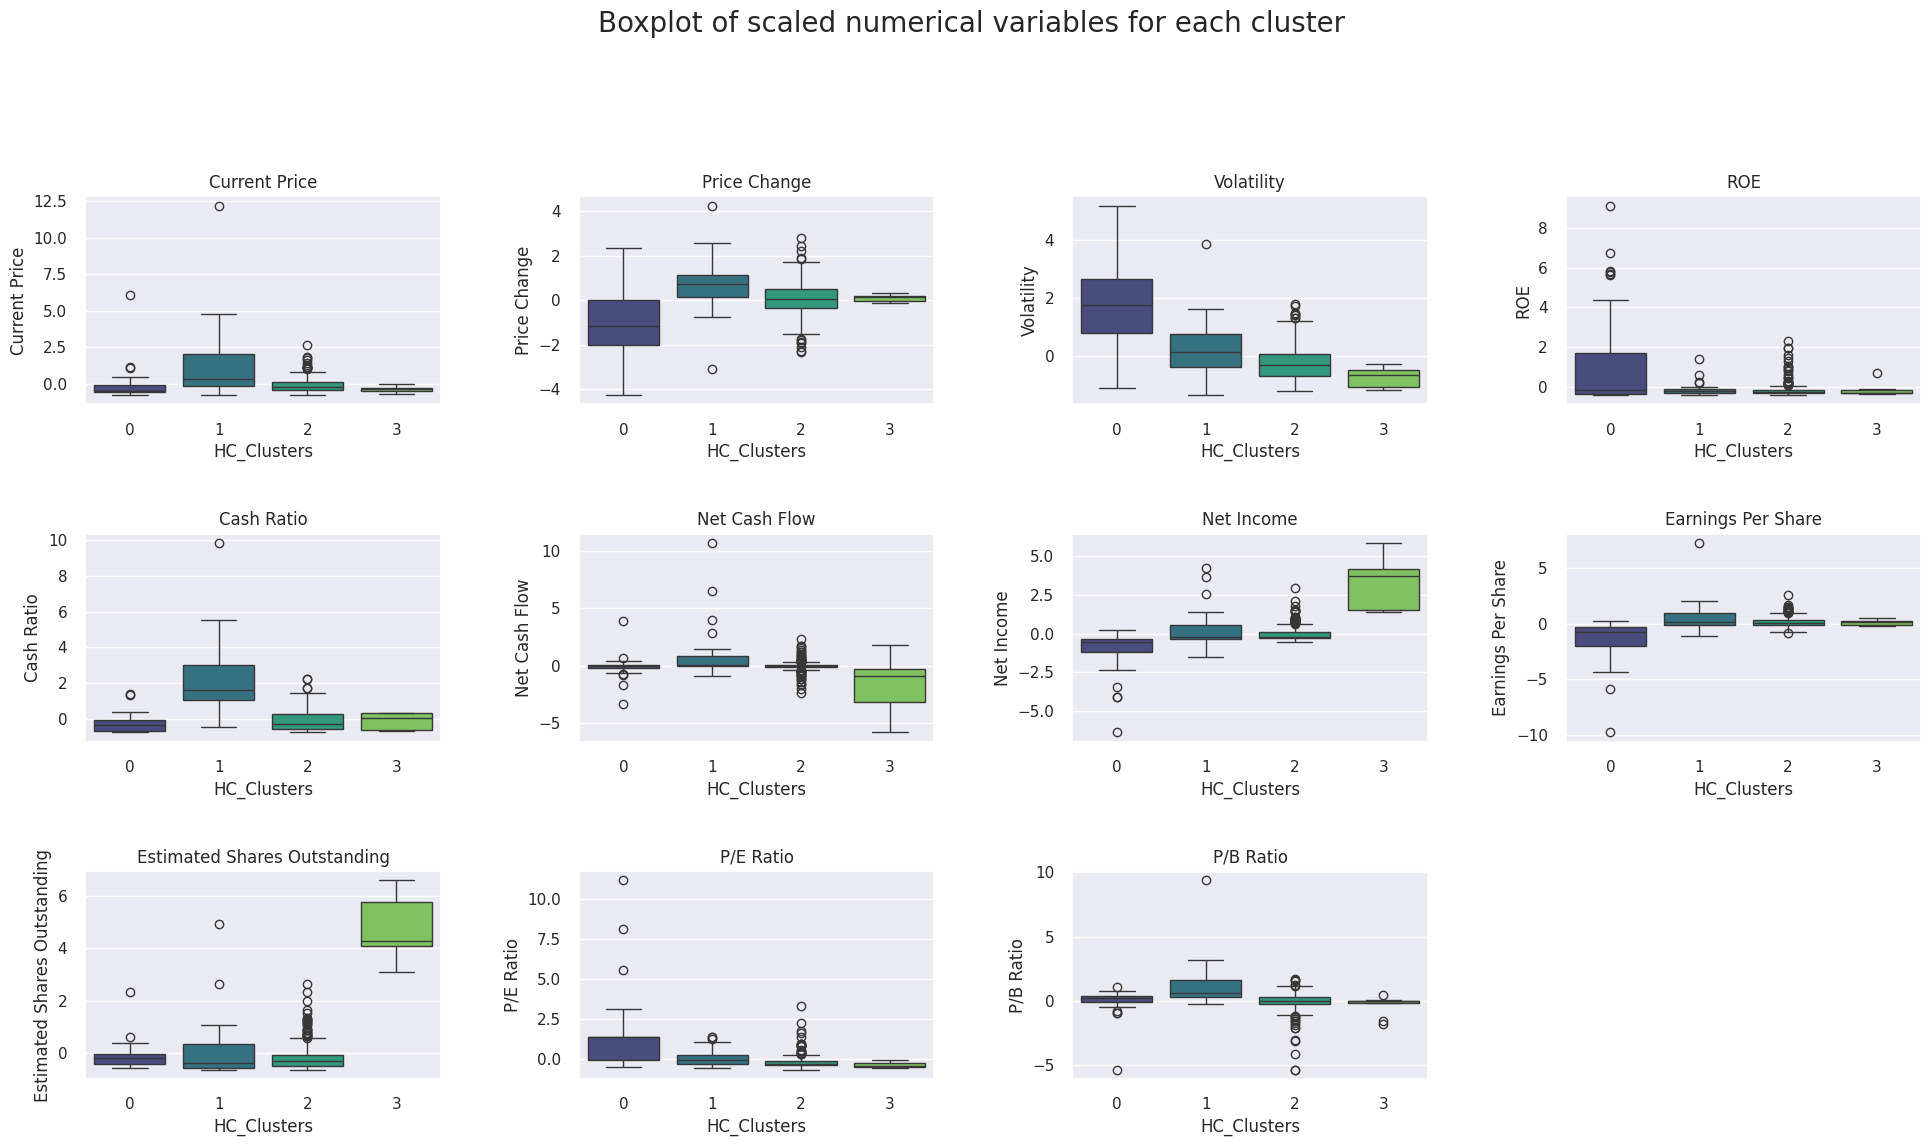

In [300]:

fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # 3 rows, 4 columns
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)

axes = axes.flatten()  # Flatten the 2D array of axes into 1D

for i in range(len(num_cols)):
    sns.boxplot(
        ax=axes[i],
        y=subset_scaled_df[num_cols[i]],
        x=subset_scaled_df["HC_Clusters"],
        palette="viridis"
    )
    axes[i].set_title(num_cols[i])

# Hide any unused axes (e.g., the 12th one if only 11 plots)
for j in range(len(num_cols), len(axes)):
    axes[j].set_visible(False)
fig.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap with suptitle

Hierarchical Clusters with ward linkage


- **Cluster 0**:High-Risk
    - 35 stocks comprised mostly of stocks within Energy
  * ROE	 163.97 (Highest)
  * Volatility	 2.58 (Highest)
  * P/E Ratio	97.97 (Highest)
  * Net Income	-2.85B (Negative)
  * EPS	-6.96 (Negative)
  * P/B Ratio	-1.85 (Negative)
  * Net Cash Flow	-1.69B
  * Count	35
  *  This cluster likely represents high-risk, overvalued stocks.
  * Despite an extremely high Return on Equity (ROE), earnings and income are negative, which suggests financial instability.

   
- **Cluster 1**: High-Performance

    - 24 stocks comprised mostly of stocks under Health Care
    * Highest Current Price - 211.164
    *Price Change - 12.46(Highest)
    * Cash Ratio - 280.25(Highest)
    * Net Cash Flow - 2.2B
    * EPS - 6.82
    * p/B Ratio - 15.68
    * It is the top-performing cluster — strong price growth, excellent cash reserves, and high profitability.
    * High P/B ratio and strong fundamentals suggest investor confidence.
    * High cash ratio implies great liquidity.

    
- **Cluster 2**: largest and most balanced cluster
    - 272 stocks belonging to the Industrial,Financial,Consumer Discretionary  
  * Current Price - 71.9
  * Price Change - 4.95 -Indicates stable or steady growth.
  * Volatility - 1.4 - Moderate
  * ROE - 24.86 -Good return on equity;
  * Net Cash Flow - -2M
  * Cash Ratio -24.86
  * Net Income - 1.5B Reflects substantial profitability at the group level.
  * EPS - 3.65
  * p/B Ratio - -3.08
  * Estimated Shares Outstanding	-445M
  * P/E Ratio - 24.29
  * Cluster 2 firms show moderate growth, stable earnings, and healthy returns
  * Moderate volatility, P/E, and income — suggests stable, mature companies.
    
- **Cluster 3**: Low Price
  - 9 stocks comprised mostly of stocks under Financials
  * Current Price	46.67 (Lowest)
  * EPS	3.43
  *Net Income	1.48B
  *P/B Ratio	-6.35 (Lowest)
  *P/E Ratio	15.59
  *Count	9 (Smallest cluster)
  *Estimated Shares	: 4.56B (Highest)
  * These may be companies with large outstanding shares, but weak market confidence.

## K-means vs Hierarchical Clustering

You compare several things, like:
- **Which clustering technique took less time for execution?**

  * K-Means clustering took lesser time for execution(.0053ms) while Hierarchial clustering took (.0089 ms)
- **Which clustering technique gave you more distinct clusters, or are they the same?**

  * Both algorithms give similar clusters, with a single cluster of a majority of the stocks and the remaining clusters containing 7-29 stocks
  * In Kmeans Clustering there was a cluster with a single stock,but no single stock clusters were found in Hierarchial cluustering

- **How many observations are there in the similar clusters of both algorithms?**
 * K-Means Clusters

   * 0 - 24
   * 1 - 34
   * 2 - 1
    *3 - 253
   *4 - 28
    
 * HC-Clusters with ward linkage

   * 0 - 35
   * 1 - 24
   * 2 - 272
   * 3 - 9

-**How many clusters are obtained as the appropriate number of clusters from both algorithms?**
  * K-Means- 5 clusters
  * Hierarchial with ward linkage - 4 clusters

**You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.**

 * Cluster 0 in K-Means clustering and Cluster 1 in Hierarchial clustering  with ward linkage also shared many similarities with respect to count in each segments and other variables like Current Price,Price change,Volatility,Highest Cash Ratio,Highest EPS,Highest P/B ratio.They both have 24 counts.

* Cluster 3 in K-Means clustering and Cluster 2 in Hierarchial clustering  with ward linkage also shared many similarities with respect to count in each segments and other variables like Current Price,Price change,Volatility,Negative Cash Flow,Negative P/B ratio,EPS etc.They have 253 and 272 observations in them respectively

* Cluster 4 in K-Means clustering and Cluster 0 in Hierarchial clustering  with ward linkage also shared many similarities with respect to variables like Current Price,Highest Volatility,Highest P/E Ratio,Negative and almost similar EPS,similar negative  Cash Flow.They have 28 and 35 observations in them respectively

## Actionable Insights and Recommendations

-

**By looking at cluster variablity -> we should use Hierarchial clustering technique(with ward linkage) in order to analyze different categories of stock and their characteristics**

**Cluster 0 -Volatile & Possibly Overvalued**

**Insights**
* Companies here have very high ROE but negative net income and EPS,which means:
  * ROE (Return on Equity) is high → Looks like the company is using its money well.

But at the same time…

    * Net income is negative → The company is actually losing money.

    * EPS (Earnings Per Share) is also negative → Each share is getting a loss, not profit.

* Extremely high P/E ratio (97.97) implies overvaluation — investors may be betting on future growth that hasn't materialized yet.

* High volatility increases investment risk.

📌**Investment Insight:**
* High-risk .
* Avoid unless there's deeper context justifying the numbers.
* Ideal for short-term traders, not long-term investors.


**Cluster 1 -High-Performing, Strong Financials**

💡**Insights:**

* Best across almost all financial metrics: high price, earnings, cash reserves, and income.

* High cash ratio (280+) suggests exceptional liquidity — great for weathering economic downturns.

* Strong fundamentals support sustainable valuation, even with a decent P/E (37.89).

* Positive price change and high EPS make this a classic growth cluster.

📌**Investment Insight:**

* Best for long-term investment.
*These are likely market leaders or dominant players in growth industries.

**Cluster 2 -Balanced & Mature**

💡**Insights:**

* Most common cluster (272 companies)

* Stable across the board with moderate P/E, volatility, income, and EPS.

* Financially healthy, but not leading in any one metric.

📌**Investment Insight:**

* These companies are a good choice for careful investors who want steady returns without taking too much risk.

**Cluster 3 - Undervalued or Underperforming**

💡**Insights:**

* Lowest price (46.67) and negative P/B ratio (-6.35) suggest deep-value or distressed stocks.
      * Deep value stocks - Stocks that look really cheap compared to what they might be worth
      * Distressed stocks - Companies that are struggling financially, maybe close to bankruptcy or dealing with major problems.
* A negative P/B means the company might have more debts than assets

* Cluster 3 has the highest net income and moderate EPS which suggest that they may be undervalued.
* Some investors see them as hidden oppurtunities. They believe the stock is undervalued.They hope that, over time, the market realizes the true value and the stock price goes up

📌 **Investment Insight:**

* Could offer value investing opportunities — but only after deep due diligence.
*These may be hidden gems or financially troubled firm